In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pyarrow as pa
import pyarrow.parquet as pq
import databento as db
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from scipy.stats import randint, uniform, loguniform, stats
import joblib
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### LOB data

In [2]:
def load_lob_data(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            dataframe = pd.read_parquet(f'C:/Users/Эвелина Новикова/{asset}_{date}.parquet')
            dataframe[f'mid_{asset}'] = (dataframe['bids[0].price'] + dataframe['asks[0].price'])/2
            dataframe[f'spread_{asset}'] = (dataframe['bids[0].price'] - dataframe['asks[0].price'])/(dataframe[f'mid_{asset}'] + 1e-12)
            dataframe[f'spread_changes_{asset}'] = dataframe[f'spread_{asset}'].diff().ne(0).rolling('1min').sum()
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'mid_{asset}': dataframe[f'mid_{asset}'],
                                                          f'spread_{asset}': dataframe[f'spread_{asset}'],
                                                          f'spread_changes_{asset}': dataframe[f'spread_changes_{asset}']})
    return dataframes

### Trades data

In [5]:
def db_preparing(path: str) -> pd.DataFrame:
    store = db.DBNStore.from_file(path)
    df = store.to_df()
    df = df.reset_index(drop=True)
    trades = df[['ts_event', 'side', 'depth', 'price', 'size']]
    trades['ts_event'] = pd.to_datetime(trades['ts_event'].astype('int64'))
    trades = trades.set_index('ts_event')
    return trades

In [7]:
def resampling(path: str) -> pd.DataFrame:
    trades = db_preparing(path)
    sides = ['A', 'B', 'N']
    res_trds = []
    for side in sides:
        side_trades = trades[trades['side'] == f'{side}']
        resampled_trades = side_trades.resample("100ms").agg({"price": "mean", "size": "sum", "depth": "max"}).fillna(0)
        res_trds.append(resampled_trades['price'])
        res_trds.append(resampled_trades['size'])
    resampled_depth = trades['depth'].resample("100ms").max().fillna(0)
    res_trds.append(resampled_depth)
    trades_resampled = pd.DataFrame(res_trds).T
    trades_resampled = trades_resampled.fillna(0)
    trades_resampled.columns = ['trade_price_A', 'trade_volume_A', 'trade_price_B', 'trade_volume_B', 'trade_price_N', 'trade_volume_N', 'depth']
    return trades_resampled

In [9]:
def load_trades(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            path = f'C:/Users/Эвелина Новикова/Downloads/xnas-itch-{date}.trades.{asset}.dbn.zst'
            dataframe = resampling(path)
            dataframe[f'buy_cnt_{asset}'] = dataframe["trade_price_B"].diff().ne(0).rolling('1min').sum()
            dataframe[f'sell_cnt_{asset}'] = dataframe["trade_price_A"].diff().ne(0).rolling('1min').sum()
            dataframe[f'buy_vol_{asset}']  = dataframe["trade_volume_B"].rolling('1min').sum()
            dataframe[f'sell_vol_{asset}']  = dataframe["trade_volume_A"].rolling('1min').sum()
            dataframe[f"cnt_imbalance_{asset}"] = (dataframe[f"buy_cnt_{asset}"] - dataframe[f"sell_cnt_{asset}"]) / (dataframe[f"buy_cnt_{asset}"] + dataframe[f"sell_cnt_{asset}"] + 1)
            dataframe[f"vol_imbalance_{asset}"] = (dataframe[f"buy_vol_{asset}"] - dataframe[f"sell_vol_{asset}"]) / (dataframe[f"buy_vol_{asset}"] + dataframe[f"sell_vol_{asset}"] + 1)
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'cnt_imbalance_{asset}': dataframe[f"cnt_imbalance_{asset}"],
                                                      f'vol_imbalance_{asset}': dataframe[f"vol_imbalance_{asset}"]})
    return dataframes

In [22]:
# dates = [20250630, 20250701, 20250702, 20250703, 20250707, 20250708, 20250709, 20250710, 20250711, 20250714, 20250715, 20250716, 20250717]

dates = [20250630, 20250701, 20250702, 20250703]

lobs = load_lob_data(dates)
trades = load_trades(dates)

In [23]:
def make_combined_lob(date):
    combined_lob = lobs[f'VXX_{date}'].join(lobs[f'SPY_{date}'], how='outer')\
           .join(lobs[f'QQQ_{date}'], how='outer')\
           .join(lobs[f'MRVL_{date}'], how='outer')\
           .join(lobs[f'ANSS_{date}'], how='outer')\
           .join(lobs[f'FAST_{date}'], how='outer')\
           .join(lobs[f'VRSK_{date}'], how='outer')
    return combined_lob.fillna(0)

In [24]:
def make_combined_trades(date):
    combined_trades = trades[f'VXX_{date}'].join(trades[f'SPY_{date}'], how='outer')\
           .join(trades[f'QQQ_{date}'], how='outer')\
           .join(trades[f'MRVL_{date}'], how='outer')\
           .join(trades[f'ANSS_{date}'], how='outer')\
           .join(trades[f'FAST_{date}'], how='outer')\
           .join(trades[f'VRSK_{date}'], how='outer')
    return combined_trades

In [25]:
combined_lob_20250630, combined_trades_20250630 = make_combined_lob(20250630), make_combined_trades(20250630)
combined_lob_20250701, combined_trades_20250701 = make_combined_lob(20250701), make_combined_trades(20250701)
combined_lob_20250702, combined_trades_20250702 = make_combined_lob(20250702), make_combined_trades(20250702)
combined_lob_20250703, combined_trades_20250703 = make_combined_lob(20250703), make_combined_trades(20250703)

### Основная торговая сессия (13:30 - 20:00)

In [26]:
def regular_lob(combined_lob):
    combined_lob = combined_lob.reset_index()
    combined_lob['datetime'] = pd.to_datetime(combined_lob['datetime'])
    filtered_lob = combined_lob[(combined_lob['datetime'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_lob['datetime'].dt.time < pd.to_datetime('19:55:00').time())]
    return filtered_lob

In [27]:
def regular_trades(combined_trades):
    combined_trades = combined_trades.reset_index()
    combined_trades['ts_event'] = pd.to_datetime(combined_trades['ts_event'])
    filtered_trades = combined_trades[(combined_trades['ts_event'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_trades['ts_event'].dt.time < pd.to_datetime('19:55:00').time())]
    filtered_trades = filtered_trades.rename(columns={'ts_event': 'datetime'})
    return filtered_trades

In [28]:
lob_20250630 = regular_lob(combined_lob_20250630)
lob_20250701 = regular_lob(combined_lob_20250701)
lob_20250702 = regular_lob(combined_lob_20250702)
lob_20250703 = regular_lob(combined_lob_20250703)

trades_20250630 = regular_trades(combined_trades_20250630)
trades_20250701 = regular_trades(combined_trades_20250701)
trades_20250702 = regular_trades(combined_trades_20250702)
trades_20250703 = regular_trades(combined_trades_20250703)

In [29]:
concatenated_lob = pd.concat([lob_20250630, lob_20250701, lob_20250702, lob_20250703])
concatenated_lob['date'] = concatenated_lob['datetime'].dt.date
concatenated_lob['day_index'] = concatenated_lob.groupby('date').ngroup()
concatenated_lob['time'] = concatenated_lob['datetime'].dt.time

concatenated_trades = pd.concat([trades_20250630, trades_20250701, trades_20250702, trades_20250703])
concatenated_trades = concatenated_trades.set_index('datetime').fillna(0)

### Скользящие волатильности и спреды

In [30]:
def calculate_rolling_fts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index('datetime')
    assets = ['ANSS', 'FAST', 'VXX', 'VRSK', 'QQQ', 'SPY', 'MRVL']
    for asset in assets:
        df[f'spread_mean_{asset}_1'] = df[f'spread_{asset}'].rolling('1min').mean().fillna(1e-8)
        df[f'spread_std_{asset}'] = df[f'spread_{asset}'].rolling('1min').std().fillna(1e-8)
        df[f'spread_mean_{asset}_5'] = df[f'spread_{asset}'].rolling('5min').mean().fillna(1e-8)
        df[f'spread_max_{asset}'] = df[f'spread_{asset}'].rolling('1min').max().fillna(1e-8)
        df[f'volatility_{asset}_1'] = df[f'mid_{asset}'].rolling('1min').std().fillna(1e-8)
        df[f'volatility_{asset}_5'] = df[f'mid_{asset}'].rolling('5min').std().fillna(1e-8)
        df[f'volatility_{asset}_30'] = df[f'mid_{asset}'].rolling('30min').std().fillna(1e-8)
    return df

In [31]:
features = calculate_rolling_fts(concatenated_lob)
features = features.join(concatenated_trades).fillna(0)

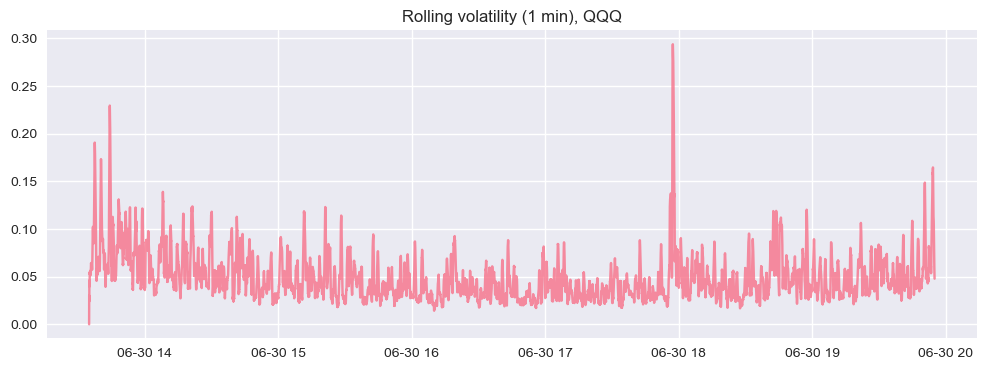

In [112]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['volatility_QQQ_1'], alpha=0.8)
plt.title('Rolling volatility (1 min), QQQ')
plt.grid(True)
plt.show()

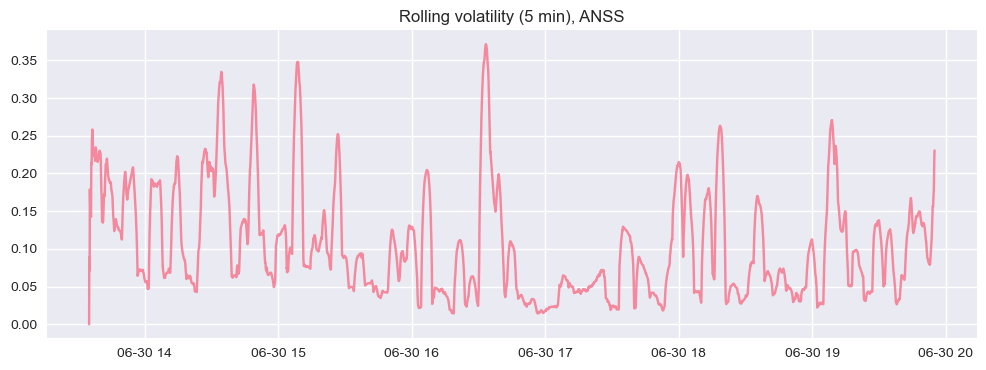

In [114]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['volatility_ANSS_5'], alpha=0.8)
plt.title('Rolling volatility (5 min), ANSS')
plt.grid(True)
plt.show()

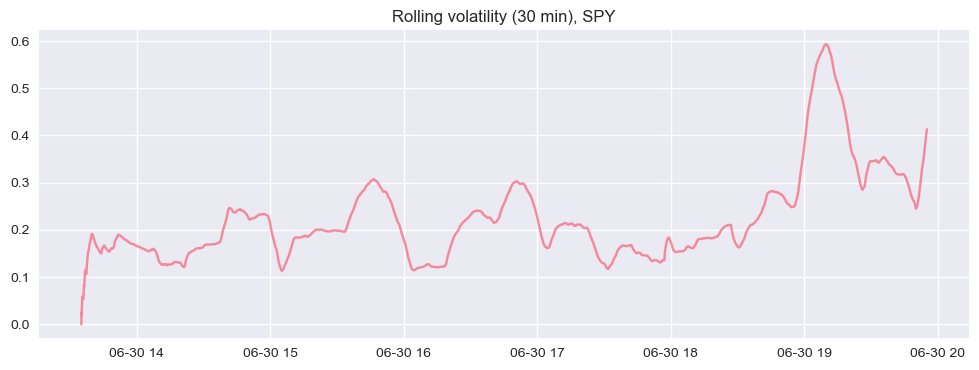

In [116]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['volatility_SPY_30'], alpha=0.8)
plt.title('Rolling volatility (30 min), SPY')
plt.grid(True)
plt.show()

## Models training

In [32]:
X = features[features['time'] != features['time'].values[len(features)-1]]
y = features[features['time'] != features['time'].values[0]]

## Baseline for SPY

In [33]:
y_SPY = y['volatility_SPY_1']
X_1_SPY = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30']]

In [34]:
X_1_SPY_train = X_1_SPY.iloc[:round(len(X_1_SPY)*0.8), :]
X_1_SPY_test = X_1_SPY.iloc[round(len(X_1_SPY)*0.8):, :]

y_SPY_train = y_SPY[:round(len(X_1_SPY)*0.8)]
y_SPY_test = y_SPY[round(len(X_1_SPY)*0.8):]

### Ridge

In [42]:
n_alphas_ridge = 1000
alphas_ridge = np.logspace(-5, 5, n_alphas_ridge)

In [126]:
coefs_ridge_1 = []   
mae_train_ridge_1 = [] 
mae_test_ridge_1 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_SPY_train, y_SPY_train)
    coefs_ridge_1.append(ridge.coef_)
    mae_train_ridge_1.append(mean_absolute_error(y_SPY_train, ridge.predict(X_1_SPY_train)))
    mae_test_ridge_1.append(mean_absolute_error(y_SPY_test, ridge.predict(X_1_SPY_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [127]:
finally_alpha_1 = alphas_ridge[np.argmin(mae_test_ridge_1)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.001200496399270259,
 0.02665452848415352)

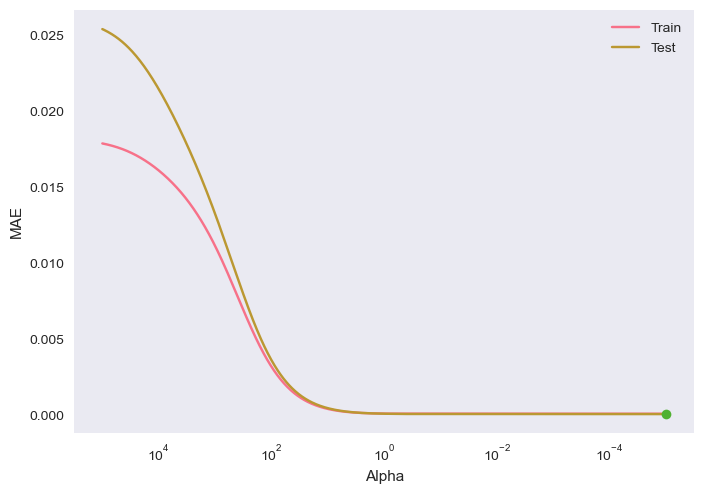

In [128]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_1, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_1, label = 'Test')

ax.plot(finally_alpha_1, mae_test_ridge_1[np.argmin(mae_test_ridge_1)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [129]:
ridge_1 = Ridge(alpha = finally_alpha_1, max_iter=1000, tol=1e-4, random_state=42)
ridge_1.fit(X_1_SPY_train, y_SPY_train)
y_SPY_1_predict = ridge_1.predict(X_1_SPY_test)

In [35]:
def sign_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = (y_true != 0) & (y_pred != 0)
    if mask.sum() == 0:
        return np.nan
    return float((np.sign(y_true[mask]) == np.sign(y_pred[mask])).mean())

In [200]:
spy_base_mae = mean_absolute_error(y_SPY_test, y_SPY_1_predict)
spy_base_r2 = r2_score(y_SPY_test, y_SPY_1_predict)
spy_base_sign_acc = sign_accuracy(y_SPY_test, y_SPY_1_predict)
print(f'Base MAE: {spy_base_mae}')
print(f'Base R2: {spy_base_r2}')
print(f'Base Sign Accuracy: {spy_base_sign_acc}')

Base MAE: 6.564109543082209e-05
Base R2: 0.9999719690642348
Base Sign Accuracy: 0.9999690423562482


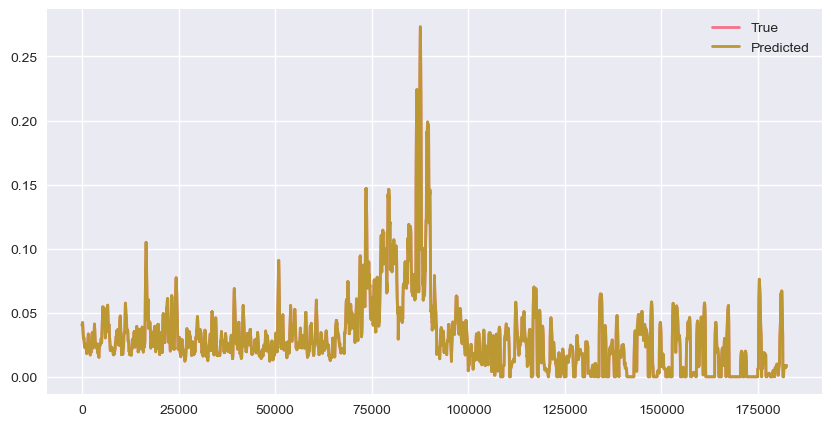

In [202]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for SPY

In [36]:
X['mean_vol_ANSS_MRVL_VRSK_FAST'] = (X['volatility_ANSS_1'] + X['volatility_MRVL_1'] + X['volatility_FAST_1'] + X['volatility_VRSK_1'])/4
X['std_vol_ANSS_MRVL_VRSK_FAST'] = ((X['volatility_ANSS_1'])**2 + (X['volatility_MRVL_1'])**2 + (X['volatility_FAST_1'])**2 + (X['volatility_VRSK_1'])**2)/4 - (X['mean_vol_ANSS_MRVL_VRSK_FAST'])**2
X['mean_spread_ANSS_MRVL_VRSK_FAST'] = (X['spread_ANSS'] + X['spread_MRVL'] + X['spread_FAST'] + X['spread_VRSK'])/4

X['mean_vol_ANSS_MRVL_FAST'] = (X['volatility_ANSS_1'] + X['volatility_MRVL_1'] + X['volatility_FAST_1'])/3
X['std_vol_ANSS_MRVL_FAST'] = ((X['volatility_ANSS_1'])**2 + (X['volatility_MRVL_1'])**2 + (X['volatility_FAST_1'])**2)/3 - (X['mean_vol_ANSS_MRVL_FAST'])**2
X['mean_spread_ANSS_MRVL_FAST'] = (X['spread_ANSS'] + X['spread_MRVL'] + X['spread_FAST'])/3

X['mean_vol_ANSS_VRSK_FAST'] = (X['volatility_ANSS_1'] + X['volatility_VRSK_1'] + X['volatility_FAST_1'])/3
X['std_vol_ANSS_VRSK_FAST'] = ((X['volatility_ANSS_1'])**2 + (X['volatility_VRSK_1'])**2 + (X['volatility_FAST_1'])**2)/3 - (X['mean_vol_ANSS_VRSK_FAST'])**2
X['mean_spread_ANSS_VRSK_FAST'] = (X['spread_ANSS'] + X['spread_VRSK'] + X['spread_FAST'])/3

X['mean_vol_MRVL_VRSK_FAST'] = (X['volatility_MRVL_1'] + X['volatility_VRSK_1'] + X['volatility_FAST_1'])/3
X['std_vol_MRVL_VRSK_FAST'] = ((X['volatility_MRVL_1'])**2 + (X['volatility_VRSK_1'])**2 + (X['volatility_FAST_1'])**2)/3 - (X['mean_vol_MRVL_VRSK_FAST'])**2
X['mean_spread_MRVL_VRSK_FAST'] = (X['spread_MRVL'] + X['spread_VRSK'] + X['spread_FAST'])/3

X['mean_vol_MRVL_VRSK_ANSS'] = (X['volatility_MRVL_1'] + X['volatility_VRSK_1'] + X['volatility_ANSS_1'])/3
X['std_vol_MRVL_VRSK_ANSS'] = ((X['volatility_MRVL_1'])**2 + (X['volatility_VRSK_1'])**2 + (X['volatility_ANSS_1'])**2)/3 - (X['mean_vol_MRVL_VRSK_ANSS'])**2
X['mean_spread_MRVL_VRSK_ANSS'] = (X['spread_MRVL'] + X['spread_VRSK'] + X['spread_ANSS'])/3


assets = ['ANSS', 'FAST', 'VXX', 'VRSK', 'QQQ', 'SPY', 'MRVL']
for asset in assets:
    X[f'spread_changes_{asset}'] = X[f'spread_changes_{asset}'] - np.min(X[f'spread_changes_{asset}'])/np.max(X[f'spread_changes_{asset}']) - np.min(X[f'spread_changes_{asset}'])

X['mean_spread_chs_ANSS_MRVL_VRSK_FAST'] = (X['spread_changes_ANSS'] + X['spread_changes_MRVL'] + X['spread_changes_FAST'] + X['spread_changes_VRSK'])/4
X['mean_cnt_imb_ANSS_MRVL_VRSK_FAST'] = (X['cnt_imbalance_ANSS'] + X['cnt_imbalance_MRVL'] + X['cnt_imbalance_FAST'] + X['cnt_imbalance_VRSK'])/4
X['mean_vol_imb_ANSS_MRVL_VRSK_FAST'] = (X['vol_imbalance_ANSS'] + X['vol_imbalance_MRVL'] + X['vol_imbalance_FAST'] + X['vol_imbalance_VRSK'])/4

X['mean_spread_chs_ANSS_MRVL_FAST'] = (X['spread_changes_ANSS'] + X['spread_changes_MRVL'] + X['spread_changes_FAST'])/3
X['mean_cnt_imb_ANSS_MRVL_FAST'] = (X['cnt_imbalance_ANSS'] + X['cnt_imbalance_MRVL'] + X['cnt_imbalance_FAST'])/3
X['mean_vol_imb_ANSS_MRVL_FAST'] = (X['vol_imbalance_ANSS'] + X['vol_imbalance_MRVL'] + X['vol_imbalance_FAST'])/3

X['mean_spread_chs_ANSS_VRSK_FAST'] = (X['spread_changes_ANSS'] + X['spread_changes_VRSK'] + X['spread_changes_FAST'])/3
X['mean_cnt_imb_ANSS_VRSK_FAST'] = (X['cnt_imbalance_ANSS'] + X['cnt_imbalance_VRSK'] + X['cnt_imbalance_FAST'])/3
X['mean_vol_imb_ANSS_VRSK_FAST'] = (X['vol_imbalance_ANSS'] + X['vol_imbalance_VRSK'] + X['vol_imbalance_FAST'])/3

X['mean_spread_chs_MRVL_VRSK_FAST'] = (X['spread_changes_MRVL'] + X['spread_changes_VRSK'] + X['spread_changes_FAST'])/3
X['mean_cnt_imb_MRVL_VRSK_FAST'] = (X['cnt_imbalance_MRVL'] + X['cnt_imbalance_VRSK'] + X['cnt_imbalance_FAST'])/3
X['mean_vol_imb_MRVL_VRSK_FAST'] = (X['vol_imbalance_MRVL'] + X['vol_imbalance_VRSK'] + X['vol_imbalance_FAST'])/3

X['mean_spread_chs_MRVL_VRSK_ANSS'] = (X['spread_changes_MRVL'] + X['spread_changes_VRSK'] + X['spread_changes_ANSS'])/3
X['mean_cnt_imb_MRVL_VRSK_ANSS'] = (X['cnt_imbalance_MRVL'] + X['cnt_imbalance_VRSK'] + X['cnt_imbalance_ANSS'])/3
X['mean_vol_imb_MRVL_VRSK_ANSS'] = (X['vol_imbalance_MRVL'] + X['vol_imbalance_VRSK'] + X['vol_imbalance_ANSS'])/3

In [37]:
X_2_SPY = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30',
             'mean_vol_ANSS_MRVL_VRSK_FAST', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_QQQ', 'spread_VXX', 'spread_SPY',
             'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ',
            'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_VRSK_FAST',
            'mean_spread_chs_ANSS_MRVL_VRSK_FAST', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]

In [38]:
X_2_SPY_train = X_2_SPY.iloc[:round(len(X_2_SPY)*0.8), :]
X_2_SPY_test = X_2_SPY.iloc[round(len(X_2_SPY)*0.8):, :]

### XGBoost

In [53]:
def make_XGB_pipeline(X: pd.DataFrame, random_state=42):
    selector_estimator = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )

    final_estimator = XGBRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.0,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )

    selector = SelectFromModel(
        estimator=selector_estimator,
        threshold="median",
        prefit=False,
        max_features=None
    )

    return Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("select", selector),
        ("model", final_estimator),
    ])

In [55]:
def tune_xgb_pipeline(X: pd.DataFrame, y: pd.Series, n_iter=40, random_state=42):
    pipe = make_XGB_pipeline(X, random_state=random_state)
    param_distributions = {
        
        # SelectFromModel 
        "select__threshold": ["median", "mean", 0.0, 1e-4, 5e-4, 1e-3],
        "select__max_features": [None, 50, 100, 200, 400],

        # тюнинг XGB внутри селектора
        "select__estimator__n_estimators": randint(200, 900),
        "select__estimator__max_depth": randint(2, 9),
        "select__estimator__learning_rate": loguniform(1e-3, 0.2),
        "select__estimator__subsample": uniform(0.6, 0.4),         # 0.6..1.0
        "select__estimator__colsample_bytree": uniform(0.6, 0.4),  # 0.6..1.0
        "select__estimator__min_child_weight": loguniform(0.3, 20.0),
        "select__estimator__reg_lambda": loguniform(1e-3, 50.0),
        "select__estimator__reg_alpha": loguniform(1e-6, 1.0),

        # Final model 
        "model__n_estimators": randint(300, 2000),
        "model__max_depth": randint(2, 10),
        "model__learning_rate": loguniform(1e-3, 0.2),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__min_child_weight": loguniform(0.3, 30.0),
        "model__reg_lambda": loguniform(1e-3, 80.0),
        "model__reg_alpha": loguniform(1e-6, 2.0),

        # регуляризационные параметры
        "model__gamma": loguniform(1e-6, 5.0),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',  
        cv=cv,
        verbose=2,
        random_state=random_state,
        n_jobs=-1,
        refit=True,
    )

    search.fit(X, y)

    print("\nBest CV score (neg MAE):", search.best_score_)
    print("Best params:")
    for k, v in search.best_params_.items():
        print(f"  {k}: {v}")

    best_model = search.best_estimator_
    return best_model, search

In [39]:
def get_selected_features(pipe: Pipeline, X: pd.DataFrame):
    mask = pipe.named_steps["select"].get_support()
    return list(X.columns[mask])

In [59]:
best_model_spy_xgb, search_spy_xgb = tune_xgb_pipeline(X_2_SPY_train, y_SPY_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -0.00018374660055186457
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [61]:
selected_spy_xgb = get_selected_features(best_model_spy_xgb, X_2_SPY_train)
print(f'Selected features: {selected_spy_xgb}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_VXX_1', 'volatility_VXX_30', 'spread_changes_VXX', 'spread_changes_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'mean_spread_ANSS_MRVL_VRSK_FAST', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']


In [63]:
y_SPY_2_predict = best_model_spy_xgb.predict(X_2_SPY_test)

In [65]:
spy_xgb_mae = mean_absolute_error(y_SPY_test, y_SPY_2_predict)
spy_xgb_r2 = r2_score(y_SPY_test, y_SPY_2_predict)
spy_xgb_sign_acc = sign_accuracy(y_SPY_test, y_SPY_2_predict)
print(f'XGB MAE: {spy_xgb_mae}')
print(f'XGB R2: {spy_xgb_r2}')
print(f'XGB Sign Accuracy: {spy_xgb_sign_acc}')

XGB MAE: 0.003142399858274377
XGB R2: 0.9288193612091058
XGB Sign Accuracy: 1.0


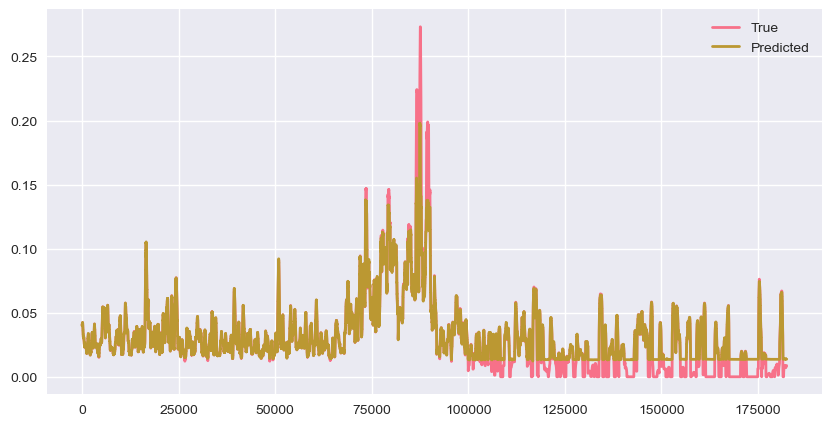

In [67]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### CatBoost

In [69]:
def make_catboost_pipeline(X: pd.DataFrame, random_state=42):
    selector_estimator = CatBoostRegressor(
        loss_function="MAE",
        random_seed=random_state,
        verbose=False,
        iterations=400,
        learning_rate=0.05,
        depth=6,
        thread_count=2
    )

    final_estimator = CatBoostRegressor(
        loss_function="MAE",
        random_seed=random_state,
        verbose=False,
        iterations=800,
        learning_rate=0.03,
        depth=8,
    )

    selector = SelectFromModel(
        estimator=selector_estimator,
        threshold="median", 
        prefit=False,
        max_features=None
    )

    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("select", selector),
        ("model", final_estimator),
    ])

    return pipe

In [51]:
def fit_catboost_pipeline(X_train: pd.DataFrame, y_train: pd.Series, random_state=42):
    pipe = make_catboost_pipeline(X_train, random_state=random_state)
    
    pipe.fit(
        X_train, y_train,
        )
    return pipe, cat_idx

def predict_with_pipeline(pipe: Pipeline, X_test: pd.DataFrame):
    return pipe.predict(X_test)

In [52]:
def tune_catboost_pipeline(X: pd.DataFrame, y: pd.Series, n_iter=30, random_state=42):
    pipe = make_catboost_pipeline(X, random_state=random_state)

    param_distributions = {
        "select__threshold": ["median", "mean"],
        "select__max_features": [None],
        "select__estimator__iterations": [300, 500],
        "select__estimator__depth": [4, 6],
        "select__estimator__learning_rate": [0.01, 0.05, 0.1],
        "select__estimator__l2_leaf_reg": [1, 3, 5],
        "select__estimator__bagging_temperature": [0.0, 1.0],
        "select__estimator__random_strength": [1.0],
        "model__iterations": randint(500, 1000),
        "model__depth": randint(6, 8),
        "model__learning_rate": loguniform(1e-2, 0.1),
        "model__l2_leaf_reg": [1, 3, 5, 10, 20],
        "model__bagging_temperature": [0.0, 0.5, 1.0],
        "model__random_strength": [1.0, 2.0],
        "model__grow_policy": ["SymmetricTree"]
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=random_state)  # Уменьшаем число фолдов

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_mean_absolute_error",
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    search.fit(X, y)

    print("\nBest CV score (neg MAE):", search.best_score_)
    print("Best params:")
    for k, v in search.best_params_.items():
        print(f"  {k}: {v}")

    best_model = search.best_estimator_
    return best_model, search

In [232]:
best_model_spy_catboost, search_spy_catboost = tune_catboost_pipeline(X_2_SPY_train, y_SPY_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -0.00025882832491625575
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 963
  model__l2_leaf_reg: 20
  model__learning_rate: 0.07217034889329342
  model__random_strength: 2.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 3
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [234]:
selected_spy_catboost = get_selected_features(best_model_spy_catboost, X_2_SPY_train)
print(f'Selected features: {selected_spy_catboost}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_30', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_SPY', 'vol_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']


In [236]:
y_SPY_3_predict = best_model_spy_catboost.predict(X_2_SPY_test)

In [238]:
spy_catboost_mae = mean_absolute_error(y_SPY_test, y_SPY_3_predict)
spy_catboost_r2 = r2_score(y_SPY_test, y_SPY_3_predict)
spy_catboost_sign_acc = sign_accuracy(y_SPY_test, y_SPY_3_predict)
print(f'CatBoost MAE: {spy_catboost_mae}')
print(f'CatBoost R2: {spy_catboost_r2}')
print(f'CatBoost Sign Accuracy: {spy_catboost_sign_acc}')

CatBoost MAE: 0.004401215278685925
CatBoost R2: 0.8364533288858085
CatBoost Sign Accuracy: 1.0


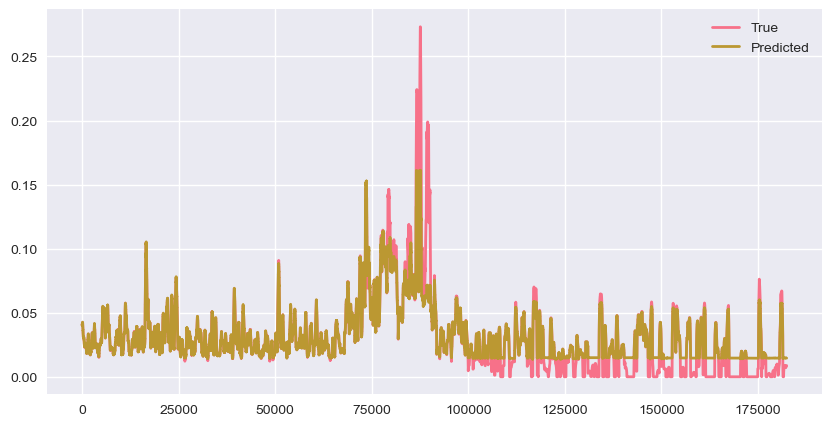

In [240]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [75]:
X_3_SPY_train = X_2_SPY_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                               'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'spread_changes_VXX', 'spread_changes_SPY',
                               'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]
X_3_SPY_test = X_2_SPY_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                               'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'spread_changes_VXX', 'spread_changes_SPY',
                               'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]

In [53]:
def make_ridge_pipeline(random_state=42):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()), 
        ("model", Ridge(random_state=random_state))
    ])

In [54]:
def tune_ridge(X: pd.DataFrame, y: pd.Series, random_state=42, time_limit_hours=2.5):
    pipe = make_ridge_pipeline(random_state=random_state)
    param_dist = {
        "model__alpha": loguniform(1e-10, 1e2),  
        "model__fit_intercept": [True, False],
        "model__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],
        "model__tol": loguniform(1e-5, 1e-1),
        "model__max_iter": [10000],
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    n_iter = int(time_limit_hours * 25) 

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter, 
        scoring="neg_mean_absolute_error",
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit=True,
        random_state=random_state
    )

    search.fit(X, y)

    print(f"\nTotal iterations: {n_iter}")
    print("Best CV score (neg MAE):", search.best_score_)
    print("Best params:")
    for k, v in search.best_params_.items():
        print(f"  {k}: {v}")

    return search.best_estimator_, search

In [183]:
best_model_SPY_ridge, search_SPY_ridge = tune_ridge(X_3_SPY_train, y_SPY_train)
y_SPY_4_predict = best_model_SPY_ridge.predict(X_3_SPY_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -8.986369526691822e-05
Best params:
  model__alpha: 6.382880092826343
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.00013046241405332336


In [184]:
spy_ridge_mae = mean_absolute_error(y_SPY_test, y_SPY_4_predict)
spy_ridge_r2 = r2_score(y_SPY_test, y_SPY_4_predict)
spy_ridge_sign_acc = sign_accuracy(y_SPY_test, y_SPY_4_predict)
print(f'Ridge MAE: {spy_ridge_mae}')
print(f'Ridge R2: {spy_ridge_r2}')
print(f'Ridge Sign Accuracy: {spy_ridge_sign_acc}')

Ridge MAE: 8.607041815528327e-05
Ridge R2: 0.999969059260627
Ridge Sign Accuracy: 1.0


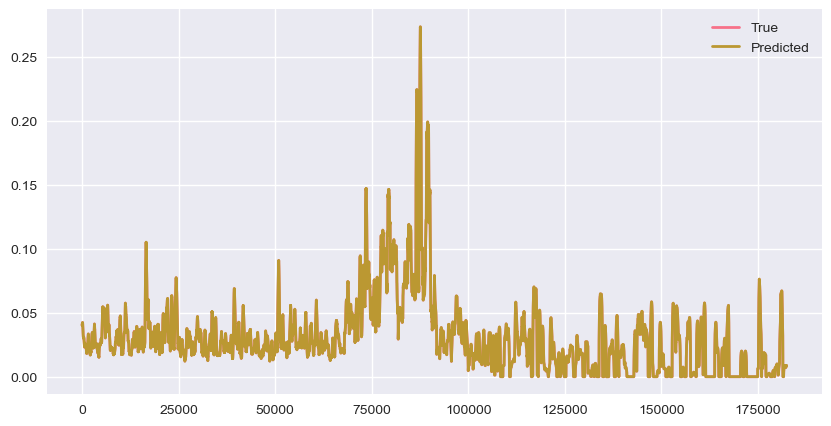

In [185]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [81]:
X_4_SPY_train = X_2_SPY_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1',
                               'volatility_VXX_5', 'mean_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_QQQ',
                               'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_VRSK_FAST', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST',
                               'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]
X_4_SPY_test = X_2_SPY_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1',
                               'volatility_VXX_5', 'mean_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_QQQ',
                               'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_VRSK_FAST', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST',
                               'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]

In [256]:
best_model_SPY_ridge_2, search_SPY_ridge_2 = tune_ridge(X_4_SPY_train, y_SPY_train)
y_SPY_5_predict = best_model_SPY_ridge_2.predict(X_4_SPY_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -9.003124705858769e-05
Best params:
  model__alpha: 6.382880092826343
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.00013046241405332336


In [258]:
spy_ridge_2_mae = mean_absolute_error(y_SPY_test, y_SPY_5_predict)
spy_ridge_2_r2 = r2_score(y_SPY_test, y_SPY_5_predict)
spy_ridge_2_sign_acc = sign_accuracy(y_SPY_test, y_SPY_5_predict)
print(f'Ridge MAE: {spy_ridge_2_mae}')
print(f'Ridge R2: {spy_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {spy_ridge_2_sign_acc}')

Ridge MAE: 0.000759390218891377
Ridge R2: 0.9987984338091552
Ridge Sign Accuracy: 1.0


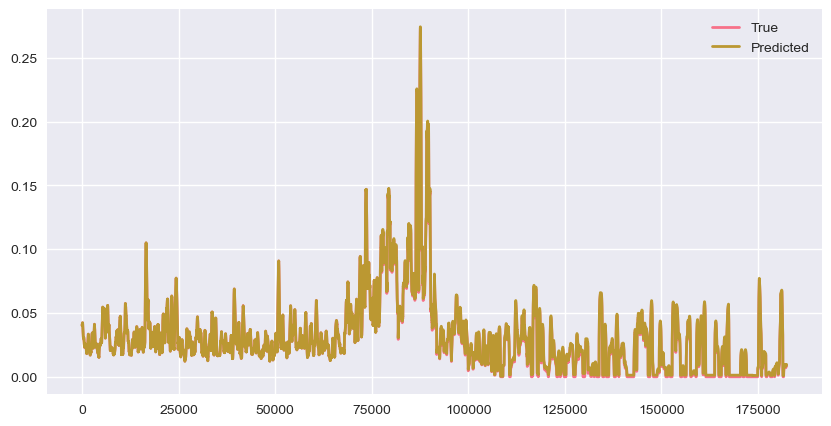

In [260]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [40]:
def make_elasticnet_pipeline(random_state=42):
    selector_est = ElasticNet(
        max_iter=200_000,
        random_state=random_state,
        selection="random"
    )
    final_est = ElasticNet(
        max_iter=200_000,
        random_state=random_state,
        selection="cyclic"
    )

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectFromModel(
            estimator=selector_est,
            threshold=1e-8,     
            prefit=False,
            max_features=10     
        )),
        ("model", final_est),
    ])
    return pipe

In [41]:
def tune_elasticnet(X: pd.DataFrame, y: pd.Series, random_state=42, n_iter=80, cv_splits=5):
    pipe = make_elasticnet_pipeline(random_state=random_state)
    param_distributions = {
       
        "select__max_features": [3, 5, 8, 10, 15, 20, 30],
        "select__threshold": [1e-10, 1e-9, 1e-8, 1e-7, 1e-6],

        # Селектор 
        "select__estimator__alpha": loguniform(1e-6, 1e-1),
        "select__estimator__l1_ratio": uniform(0.80, 0.20),  # 0.80..1.00
        "select__estimator__tol": loguniform(1e-7, 1e-3),

        # Финальная модель 
        "model__alpha": loguniform(1e-7, 1e-1),
        "model__l1_ratio": uniform(0.0, 1.0),
        "model__tol": loguniform(1e-7, 1e-3),
        "model__fit_intercept": [True, False],
    }

    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_mean_absolute_error",
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=2,
        refit=True,
    )

    search.fit(X, y)

    print("\nBest CV score (neg MAE):", search.best_score_)
    print("Best params:")
    for k, v in search.best_params_.items():
        print(f"  {k}: {v}")

    return search.best_estimator_, search

In [42]:
best_model_SPY_elnet, search_SPY_elnet = tune_elasticnet(X_2_SPY_train, y_SPY_train, n_iter=25, cv_splits=5)
y_SPY_6_predict = best_model_SPY_elnet.predict(X_2_SPY_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -8.959378427383341e-05
Best params:
  model__alpha: 2.915769128839452e-06
  model__fit_intercept: True
  model__l1_ratio: 0.32320293202075523
  model__tol: 1.188946976953047e-05
  select__estimator__alpha: 0.0032741215209888836
  select__estimator__l1_ratio: 0.8727259204758588
  select__estimator__tol: 0.0007711312991331104
  select__max_features: 10
  select__threshold: 1e-07


In [43]:
best_model_SPY_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.0032741215209888836,
                                                      l1_ratio=0.8727259204758588,
                                                      max_iter=200000,
                                                      random_state=42,
                                                      selection='random',
                                                      tol=0.0007711312991331104),
                                 max_features=10, threshold=1e-07)),
                ('model',
                 ElasticNet(alpha=2.915769128839452e-06,
                            l1_ratio=0.32320293202075523, max_iter=200000,
                            random_state=42, tol=1.188946976953047e-05))])

In [86]:
spy_elnet_mae = mean_absolute_error(y_SPY_test, y_SPY_6_predict)
spy_elnet_r2 = r2_score(y_SPY_test, y_SPY_6_predict)
spy_elnet_sign_acc = sign_accuracy(y_SPY_test, y_SPY_6_predict)
print(f'Elastic Net MAE: {spy_elnet_mae}')
print(f'Elastic Net R2: {spy_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {spy_elnet_sign_acc}')

Elastic Net MAE: 6.502272069131197e-05
Elastic Net R2: 0.9999719299206039
Elastic Net Sign Accuracy: 1.0


In [87]:
selected_spy_elnet = get_selected_features(best_model_SPY_elnet, X_2_SPY_train)
print(f'Selected features: {selected_spy_elnet}')

Selected features: ['volatility_SPY_1', 'volatility_QQQ_1']


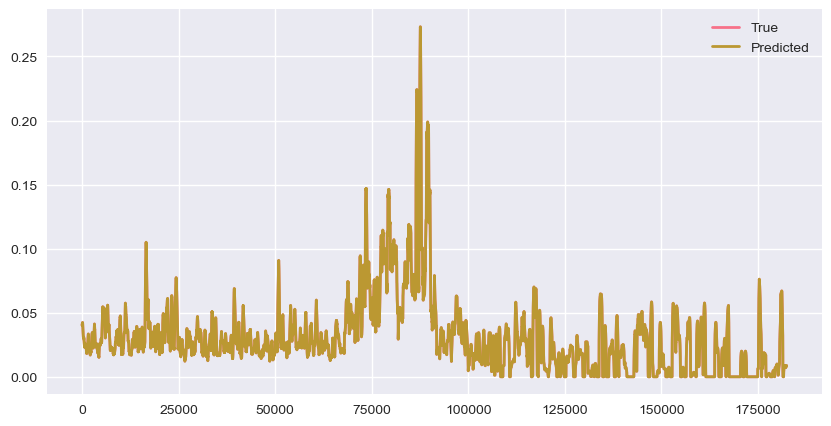

In [88]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for QQQ

In [89]:
y_QQQ = y['volatility_QQQ_1']
X_1_QQQ = X[['volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_QQQ_30']]

In [90]:
X_1_QQQ_train = X_1_QQQ.iloc[:round(len(X_1_QQQ)*0.8), :]
X_1_QQQ_test = X_1_QQQ.iloc[round(len(X_1_QQQ)*0.8):, :]

y_QQQ_train = y_QQQ[:round(len(X_1_QQQ)*0.8)]
y_QQQ_test = y_QQQ[round(len(X_1_QQQ)*0.8):]

### Ridge

In [155]:
coefs_ridge_2 = []   
mae_train_ridge_2 = [] 
mae_test_ridge_2 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_QQQ_train, y_QQQ_train)
    coefs_ridge_2.append(ridge.coef_)
    mae_train_ridge_2.append(mean_absolute_error(y_QQQ_train, ridge.predict(X_1_QQQ_train)))
    mae_test_ridge_2.append(mean_absolute_error(y_QQQ_test, ridge.predict(X_1_QQQ_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [156]:
finally_alpha_2 = alphas_ridge[np.argmin(mae_test_ridge_2)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.0014796973458930855,
 0.03218410347506213)

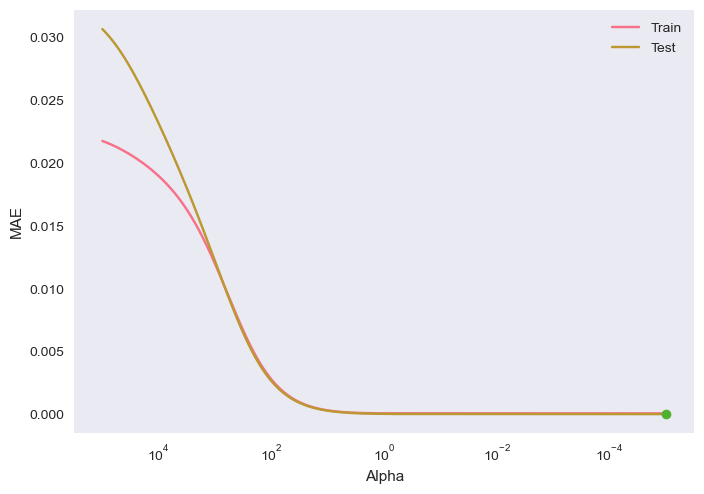

In [157]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_2, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_2, label = 'Test')

ax.plot(finally_alpha_2, mae_test_ridge_2[np.argmin(mae_test_ridge_2)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [158]:
ridge_2 = Ridge(alpha = finally_alpha_2, max_iter=1000, tol=1e-4, random_state=42)
ridge_2.fit(X_1_QQQ_train, y_QQQ_train)
y_QQQ_1_predict = ridge_2.predict(X_1_QQQ_test)

In [159]:
qqq_base_mae = mean_absolute_error(y_QQQ_test, y_QQQ_1_predict)
qqq_base_r2 = r2_score(y_QQQ_test, y_QQQ_1_predict)
qqq_base_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_1_predict)
print(f'Ridge MAE: {qqq_base_mae}')
print(f'Ridge R2: {qqq_base_r2}')
print(f'Ridge Sign Accuracy: {qqq_base_sign_acc}')

Ridge MAE: 5.0475418695788076e-05
Ridge R2: 0.9999828861837331
Ridge Sign Accuracy: 1.0


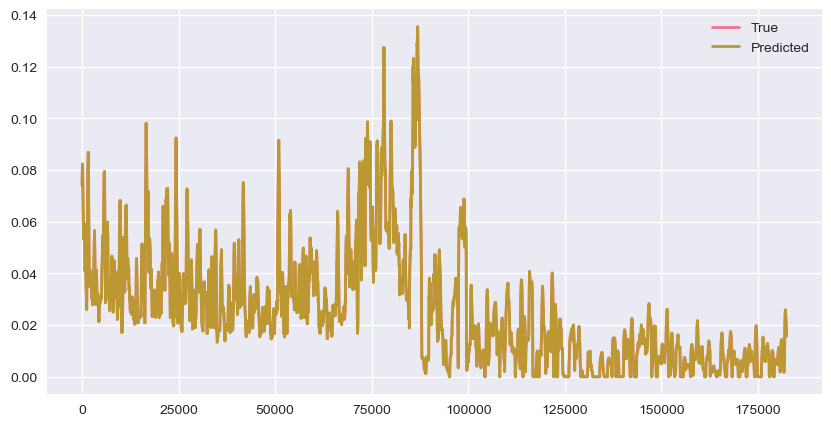

In [160]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for QQQ

In [91]:
X_2_QQQ = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30',
             'mean_vol_ANSS_MRVL_VRSK_FAST', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_QQQ', 'spread_VXX', 'spread_SPY',
             'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ',
            'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_VRSK_FAST',
            'mean_spread_chs_ANSS_MRVL_VRSK_FAST', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]

In [92]:
X_2_QQQ_train = X_2_QQQ.iloc[:round(len(X_2_QQQ)*0.8), :]
X_2_QQQ_test = X_2_QQQ.iloc[round(len(X_2_QQQ)*0.8):, :]

### XGBoost

In [191]:
best_model_qqq_xgb, search_qqq_xgb = tune_xgb_pipeline(X_2_QQQ_train, y_QQQ_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -0.0002268467687142473
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [192]:
selected_qqq_xgb = get_selected_features(best_model_qqq_xgb, X_2_QQQ_train)
print(f'Selected features: {selected_qqq_xgb}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']


In [193]:
y_QQQ_2_predict = best_model_qqq_xgb.predict(X_2_QQQ_test)

In [194]:
qqq_xgb_mae = mean_absolute_error(y_QQQ_test, y_QQQ_2_predict)
qqq_xgb_r2 = r2_score(y_QQQ_test, y_QQQ_2_predict)
qqq_xgb_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_2_predict)
print(f'XGB MAE: {qqq_xgb_mae}')
print(f'XGB R2: {qqq_xgb_r2}')
print(f'XGB Sign Accuracy: {qqq_xgb_sign_acc}')

XGB MAE: 0.004563377424872694
XGB R2: 0.8805409039937352
XGB Sign Accuracy: 1.0


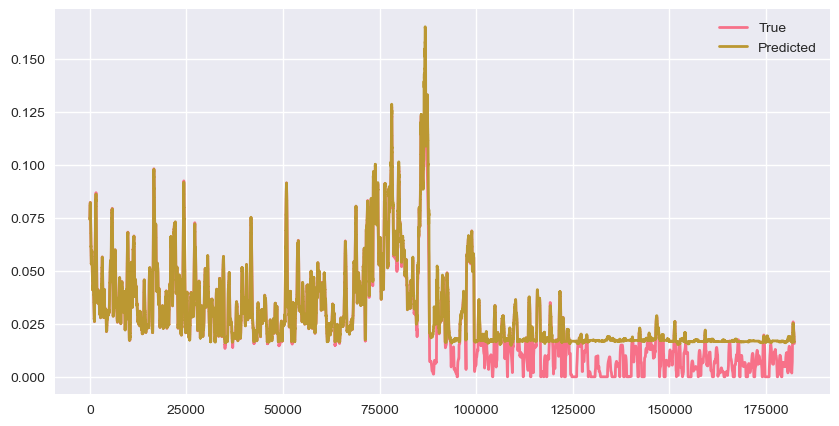

In [195]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Catboost

In [314]:
best_model_qqq_catboost, search_qqq_catboost = tune_catboost_pipeline(X_2_QQQ_train, y_QQQ_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -0.000316195818835765
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 963
  model__l2_leaf_reg: 20
  model__learning_rate: 0.07217034889329342
  model__random_strength: 2.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 3
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [316]:
selected_qqq_catboost = get_selected_features(best_model_qqq_catboost, X_2_QQQ_train)
print(f'Selected features: {selected_qqq_catboost}')

Selected features: ['volatility_SPY_1', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'mean_vol_ANSS_MRVL_VRSK_FAST', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST']


In [318]:
y_QQQ_3_predict = best_model_qqq_catboost.predict(X_2_QQQ_test)

In [425]:
qqq_catboost_mae = mean_absolute_error(y_QQQ_test, y_QQQ_3_predict)
qqq_catboost_r2 = r2_score(y_QQQ_test, y_QQQ_3_predict)
qqq_catboost_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_3_predict)
print(f'CatBoost MAE: {qqq_catboost_mae}')
print(f'CatBoost R2: {qqq_catboost_r2}')
print(f'CatBoost Sign Accuracy: {qqq_catboost_sign_acc}')

CatBoost MAE: 0.004612369895019008
CatBoost R2: 0.8788759996187704
CatBoost Sign Accuracy: 1.0


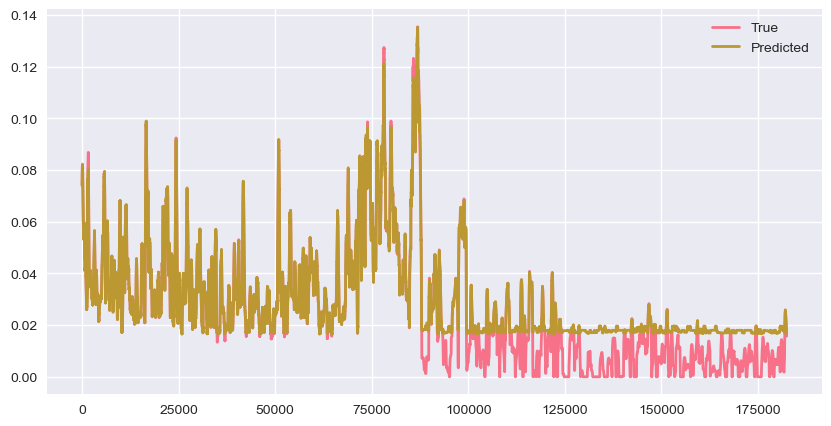

In [322]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [95]:
X_3_QQQ_train = X_2_QQQ_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_30', 'volatility_VXX_1',
                               'volatility_VXX_30', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_QQQ', 'vol_imbalance_QQQ',
                               'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']]
X_3_QQQ_test = X_2_QQQ_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_30', 'volatility_VXX_1',
                               'volatility_VXX_30', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_QQQ', 'vol_imbalance_QQQ',
                               'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']]

In [97]:
best_model_QQQ_ridge, search_QQQ_ridge = tune_ridge(X_3_QQQ_train, y_QQQ_train)
y_QQQ_4_predict = best_model_QQQ_ridge.predict(X_3_QQQ_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.00010629524556125003
Best params:
  model__alpha: 5.1369812657189255
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: svd
  model__tol: 3.07858974802593e-05


In [98]:
qqq_ridge_mae = mean_absolute_error(y_QQQ_test, y_QQQ_4_predict)
qqq_ridge_r2 = r2_score(y_QQQ_test, y_QQQ_4_predict)
qqq_ridge_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_4_predict)
print(f'Ridge MAE: {qqq_ridge_mae}')
print(f'Ridge R2: {qqq_ridge_r2}')
print(f'Ridge Sign Accuracy: {qqq_ridge_sign_acc}')

Ridge MAE: 0.00016445421770785713
Ridge R2: 0.9994342295075637
Ridge Sign Accuracy: 0.9999940848003028


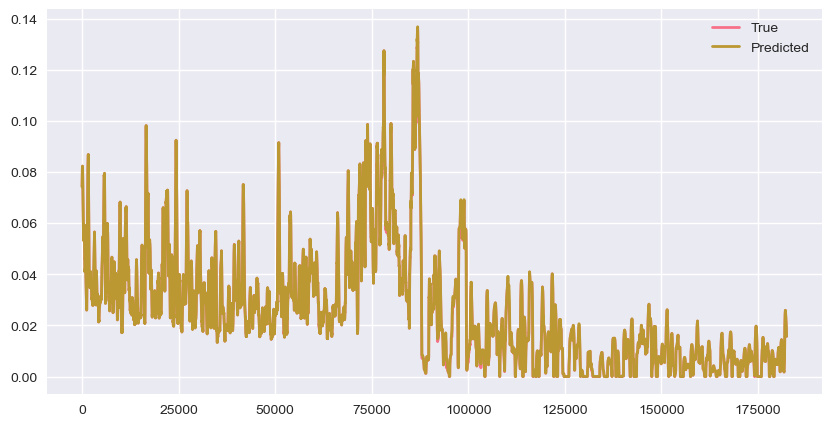

In [99]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [ ]:
X_4_QQQ_train = X_2_QQQ_train[['volatility_SPY_1', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'mean_vol_ANSS_MRVL_VRSK_FAST',
                               'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ',
                               'vol_imbalance_QQQ', 'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST']]
X_4_QQQ_test = X_2_QQQ_test[['volatility_SPY_1', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'mean_vol_ANSS_MRVL_VRSK_FAST',
                               'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ',
                               'vol_imbalance_QQQ', 'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_spread_chs_ANSS_MRVL_VRSK_FAST']]

In [197]:
best_model_QQQ_ridge_2, search_QQQ_ridge_2 = tune_ridge(X_4_QQQ_train, y_QQQ_train)
y_QQQ_5_predict = best_model_QQQ_ridge_2.predict(X_4_QQQ_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.00010632724911858455
Best params:
  model__alpha: 6.382880092826343
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.00013046241405332336


In [198]:
qqq_ridge_2_mae = mean_absolute_error(y_QQQ_test, y_QQQ_5_predict)
qqq_ridge_2_r2 = r2_score(y_QQQ_test, y_QQQ_5_predict)
qqq_ridge_2_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_5_predict)
print(f'Ridge MAE: {qqq_ridge_2_mae}')
print(f'Ridge R2: {qqq_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {qqq_ridge_2_sign_acc}')

Ridge MAE: 0.00010645156943026324
Ridge R2: 0.9999116808903428
Ridge Sign Accuracy: 0.9999940848003028


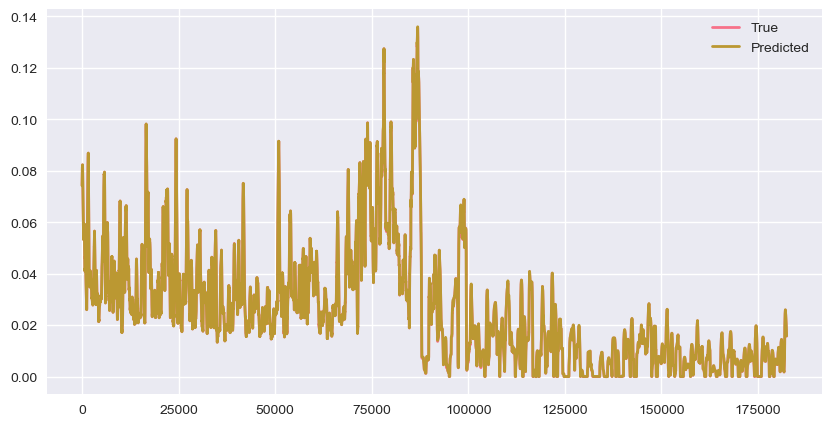

In [199]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [93]:
best_model_QQQ_elnet, search_QQQ_elnet = tune_elasticnet(X_2_QQQ_train, y_QQQ_train, n_iter=25, cv_splits=5)
y_QQQ_6_predict = best_model_QQQ_elnet.predict(X_2_QQQ_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -0.0001059150164937466
Best params:
  model__alpha: 3.6726120005986885e-06
  model__fit_intercept: True
  model__l1_ratio: 0.09310276780589921
  model__tol: 0.0003880279700786684
  select__estimator__alpha: 0.031775345821188294
  select__estimator__l1_ratio: 0.9266202914546536
  select__estimator__tol: 2.2704877557909207e-06
  select__max_features: 8
  select__threshold: 1e-08


In [94]:
best_model_QQQ_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.031775345821188294,
                                                      l1_ratio=0.9266202914546536,
                                                      max_iter=200000,
                                                      random_state=42,
                                                      selection='random',
                                                      tol=2.2704877557909207e-06),
                                 max_features=8, threshold=1e-08)),
                ('model',
                 ElasticNet(alpha=3.6726120005986885e-06,
                            l1_ratio=0.09310276780589921, max_iter=200000,
                            random_state=42, tol=0.0003880279700786684))])

In [95]:
qqq_elnet_mae = mean_absolute_error(y_QQQ_test, y_QQQ_6_predict)
qqq_elnet_r2 = r2_score(y_QQQ_test, y_QQQ_6_predict)
qqq_elnet_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_6_predict)
print(f'Elastic Net MAE: {qqq_elnet_mae}')
print(f'Elastic Net R2: {qqq_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {qqq_elnet_sign_acc}')

Elastic Net MAE: 4.934224264980666e-05
Elastic Net R2: 0.9999829314161762
Elastic Net Sign Accuracy: 1.0


In [96]:
selected_qqq_elnet = get_selected_features(best_model_QQQ_elnet, X_2_QQQ_train)
print(f'Selected features: {selected_qqq_elnet}')

Selected features: ['volatility_QQQ_1']


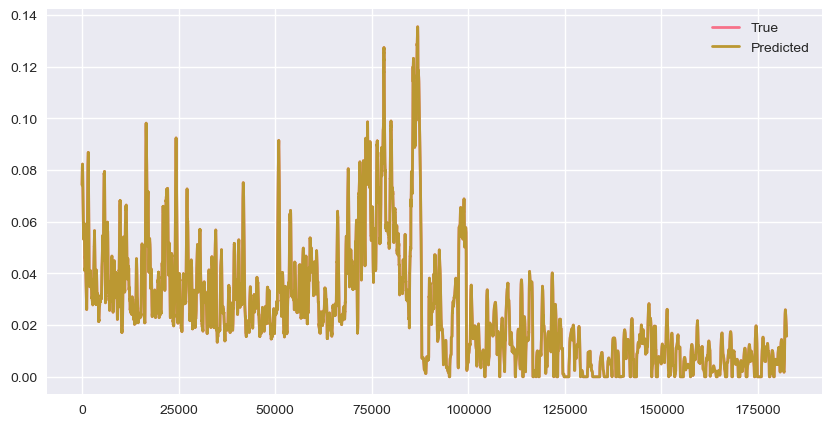

In [97]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for VXX

In [98]:
y_VXX = y['volatility_VXX_1']
X_1_VXX = X[['volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30']]

In [99]:
X_1_VXX_train = X_1_VXX.iloc[:round(len(X_1_VXX)*0.8), :]
X_1_VXX_test = X_1_VXX.iloc[round(len(X_1_VXX)*0.8):, :]

y_VXX_train = y_VXX[:round(len(X_1_VXX)*0.8)]
y_VXX_test = y_VXX[round(len(X_1_VXX)*0.8):]

### Ridge

In [86]:
coefs_ridge_3 = []   
mae_train_ridge_3 = [] 
mae_test_ridge_3 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_VXX_train, y_VXX_train)
    coefs_ridge_3.append(ridge.coef_)
    mae_train_ridge_3.append(mean_absolute_error(y_VXX_train, ridge.predict(X_1_VXX_train)))
    mae_test_ridge_3.append(mean_absolute_error(y_VXX_test, ridge.predict(X_1_VXX_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [87]:
finally_alpha_3 = alphas_ridge[np.argmin(mae_test_ridge_3)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.0009319672947207632,
 0.020194545457813295)

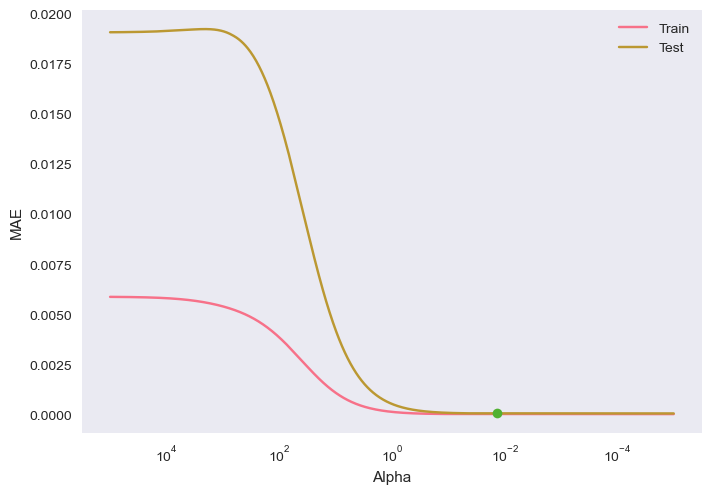

In [90]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_3, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_3, label = 'Test')

ax.plot(finally_alpha_3, mae_test_ridge_3[np.argmin(mae_test_ridge_3)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [92]:
ridge_3 = Ridge(alpha = finally_alpha_3, max_iter=1000, tol=1e-4, random_state=42)
ridge_3.fit(X_1_VXX_train, y_VXX_train)
y_VXX_1_predict = ridge_3.predict(X_1_VXX_test)

In [104]:
vxx_base_mae = mean_absolute_error(y_VXX_test, y_VXX_1_predict)
vxx_base_r2 = r2_score(y_VXX_test, y_VXX_1_predict)
vxx_base_sign_acc = sign_accuracy(y_VXX_test, y_VXX_1_predict)
print(f'Ridge MAE: {vxx_base_mae}')
print(f'Ridge R2: {vxx_base_r2}')
print(f'Ridge Sign Accuracy: {vxx_base_sign_acc}')

Ridge MAE: 5.9878997723347914e-05
Ridge R2: 0.9999162210840613
Ridge Sign Accuracy: 0.9998663225328795


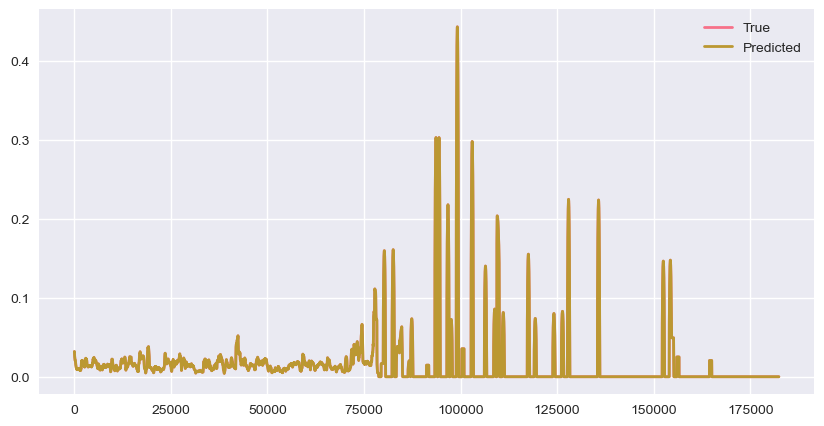

In [108]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for VXX

In [100]:
X_2_VXX = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30',
             'mean_vol_ANSS_MRVL_VRSK_FAST', 'std_vol_ANSS_MRVL_VRSK_FAST', 'spread_QQQ', 'spread_VXX', 'spread_SPY',
             'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ',
            'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY', 'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_VRSK_FAST',
            'mean_spread_chs_ANSS_MRVL_VRSK_FAST', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST', 'mean_vol_imb_ANSS_MRVL_VRSK_FAST']]

In [101]:
X_2_VXX_train = X_2_VXX.iloc[:round(len(X_2_VXX)*0.8), :]
X_2_VXX_test = X_2_VXX.iloc[round(len(X_2_VXX)*0.8):, :]

### XGBoost

In [344]:
best_model_vxx_xgb, search_vxx_xgb = tune_xgb_pipeline(X_2_VXX_train, y_VXX_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -8.504180326057015e-05
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [411]:
selected_vxx_xgb = get_selected_features(best_model_vxx_xgb, X_2_VXX_train)
print(f'Selected features: {selected_vxx_xgb}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'mean_vol_ANSS_MRVL_VRSK_FAST', 'spread_changes_VXX', 'cnt_imbalance_QQQ', 'vol_imbalance_VXX', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']


In [413]:
y_VXX_2_predict = best_model_vxx_xgb.predict(X_2_VXX_test)

In [415]:
vxx_xgb_mae = mean_absolute_error(y_VXX_test, y_VXX_2_predict)
vxx_xgb_r2 = r2_score(y_VXX_test, y_VXX_2_predict)
vxx_xgb_sign_acc = sign_accuracy(y_VXX_test, y_VXX_2_predict)
print(f'XGB MAE: {vxx_xgb_mae}')
print(f'XGB R2: {vxx_xgb_r2}')
print(f'XGB Sign Accuracy: {vxx_xgb_sign_acc}')

XGB MAE: 0.00819444908287814
XGB R2: 0.38014133336958433
XGB Sign Accuracy: 1.0


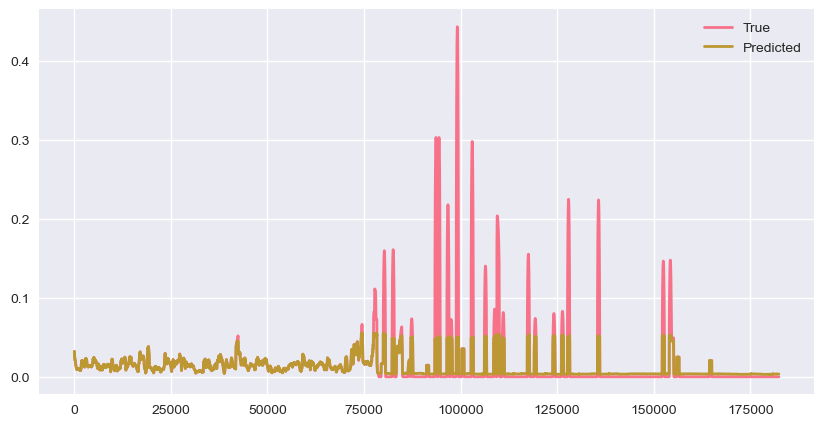

In [417]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### CatBoost

In [346]:
best_model_vxx_catboost, search_vxx_catboost = tune_catboost_pipeline(X_2_VXX_train, y_VXX_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -7.833977513950175e-05
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 851
  model__l2_leaf_reg: 10
  model__learning_rate: 0.08720136124683266
  model__random_strength: 2.0
  select__estimator__bagging_temperature: 1.0
  select__estimator__depth: 4
  select__estimator__iterations: 500
  select__estimator__l2_leaf_reg: 1
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: mean


In [419]:
selected_vxx_catboost = get_selected_features(best_model_vxx_catboost, X_2_VXX_train)
print(f'Selected features: {selected_vxx_catboost}')

Selected features: ['volatility_VXX_1']


In [421]:
y_VXX_3_predict = best_model_vxx_catboost.predict(X_2_VXX_test)

In [427]:
vxx_catboost_mae = mean_absolute_error(y_VXX_test, y_VXX_3_predict)
vxx_catboost_r2 = r2_score(y_VXX_test, y_VXX_3_predict)
vxx_catboost_sign_acc = sign_accuracy(y_VXX_test, y_VXX_3_predict)
print(f'CatBoost MAE: {vxx_catboost_mae}')
print(f'CatBoost R2: {vxx_catboost_r2}')
print(f'CatBoost Sign Accuracy: {vxx_catboost_sign_acc}')

CatBoost MAE: 0.007772055587873755
CatBoost R2: 0.437911570969161
CatBoost Sign Accuracy: 1.0


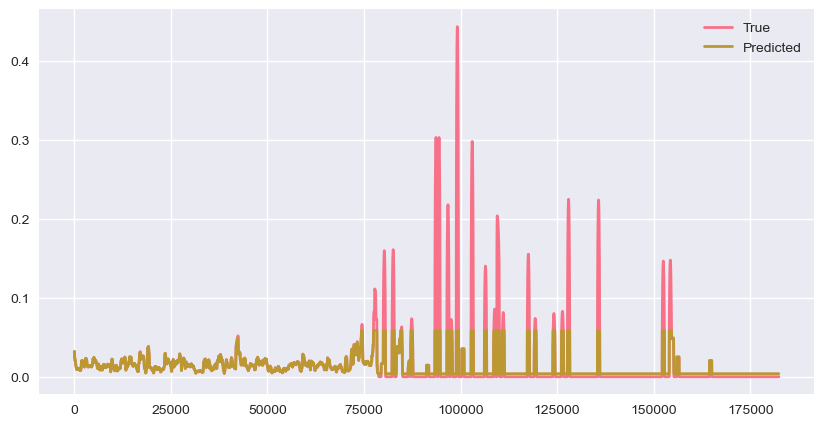

In [429]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [201]:
X_3_VXX_train = X_2_VXX_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                               'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'mean_vol_ANSS_MRVL_VRSK_FAST',
                               'spread_changes_VXX', 'cnt_imbalance_QQQ', 'vol_imbalance_VXX', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']]
X_3_VXX_test = X_2_VXX_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                               'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'mean_vol_ANSS_MRVL_VRSK_FAST',
                               'spread_changes_VXX', 'cnt_imbalance_QQQ', 'vol_imbalance_VXX', 'mean_cnt_imb_ANSS_MRVL_VRSK_FAST']]

In [202]:
best_model_VXX_ridge, search_VXX_ridge = tune_ridge(X_3_VXX_train, y_VXX_train)
y_VXX_4_predict = best_model_VXX_ridge.predict(X_3_VXX_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -2.8381943980021207e-05
Best params:
  model__alpha: 8.40611014836318e-06
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: sag
  model__tol: 8.226074946221034e-05


In [203]:
vxx_ridge_mae = mean_absolute_error(y_VXX_test, y_VXX_4_predict)
vxx_ridge_r2 = r2_score(y_VXX_test, y_VXX_4_predict)
vxx_ridge_sign_acc = sign_accuracy(y_VXX_test, y_VXX_4_predict)
print(f'Ridge MAE: {vxx_ridge_mae}')
print(f'Ridge R2: {vxx_ridge_r2}')
print(f'Ridge Sign Accuracy: {vxx_ridge_sign_acc}')

Ridge MAE: 6.090787794527139e-05
Ridge R2: 0.9999162475416831
Ridge Sign Accuracy: 0.9998868882970519


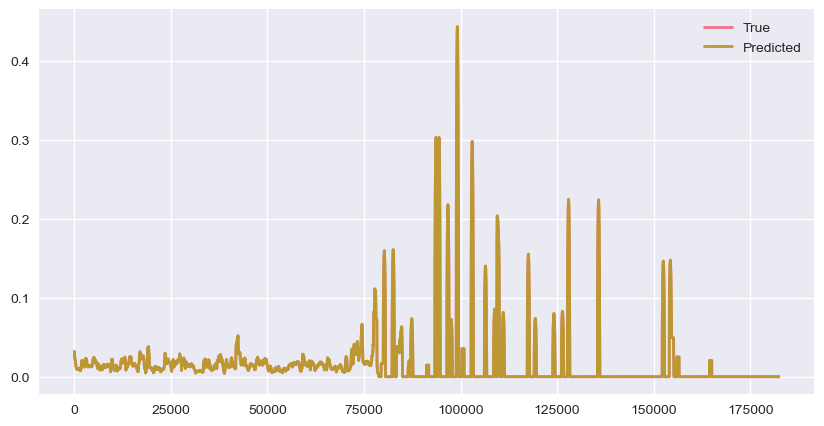

In [204]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [205]:
X_4_VXX_train = X_2_VXX_train[['volatility_VXX_1']]
X_4_VXX_test = X_2_VXX_test[['volatility_VXX_1']]

In [206]:
best_model_VXX_ridge_2, search_VXX_ridge_2 = tune_ridge(X_4_VXX_train, y_VXX_train)
y_VXX_5_predict = best_model_VXX_ridge_2.predict(X_4_VXX_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -2.8209305483994804e-05
Best params:
  model__alpha: 8.40611014836318e-06
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: sag
  model__tol: 8.226074946221034e-05


In [207]:
vxx_ridge_2_mae = mean_absolute_error(y_VXX_test, y_VXX_5_predict)
vxx_ridge_2_r2 = r2_score(y_VXX_test, y_VXX_5_predict)
vxx_ridge_2_sign_acc = sign_accuracy(y_VXX_test, y_VXX_5_predict)
print(f'Ridge MAE: {vxx_ridge_2_mae}')
print(f'Ridge R2: {vxx_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {vxx_ridge_2_sign_acc}')

Ridge MAE: 5.4567482674239886e-05
Ridge R2: 0.999916126751132
Ridge Sign Accuracy: 0.9997223621836728


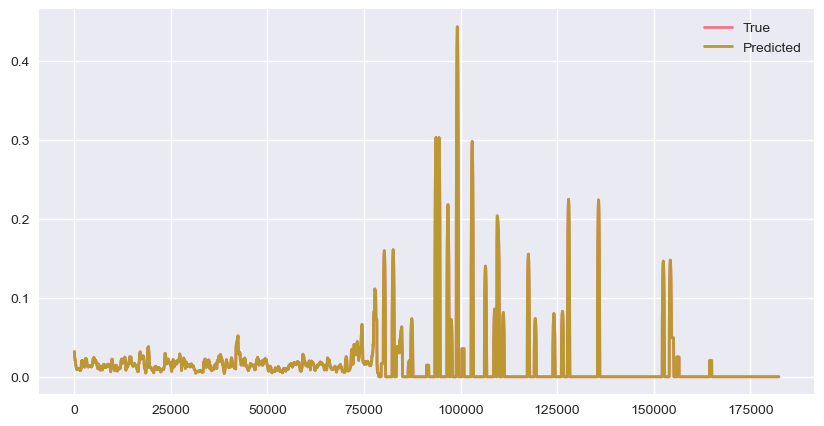

In [208]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [102]:
best_model_VXX_elnet, search_VXX_elnet = tune_elasticnet(X_2_VXX_train, y_VXX_train, n_iter=25, cv_splits=5)
y_VXX_6_predict = best_model_VXX_elnet.predict(X_2_VXX_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -2.8244882184553343e-05
Best params:
  model__alpha: 4.795579858030172e-07
  model__fit_intercept: True
  model__l1_ratio: 0.5414479738275658
  model__tol: 6.069285921193291e-05
  select__estimator__alpha: 1.3891530890192501e-05
  select__estimator__l1_ratio: 0.8349909854191873
  select__estimator__tol: 0.0008485420586212643
  select__max_features: 10
  select__threshold: 1e-07


In [103]:
best_model_VXX_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=1.3891530890192501e-05,
                                                      l1_ratio=0.8349909854191873,
                                                      max_iter=200000,
                                                      random_state=42,
                                                      selection='random',
                                                      tol=0.0008485420586212643),
                                 max_features=10, threshold=1e-07)),
                ('model',
                 ElasticNet(alpha=4.795579858030172e-07,
                            l1_ratio=0.5414479738275658, max_iter=200000,
                            random_state=42, tol=6.069285921193291e-05))])

In [104]:
vxx_elnet_mae = mean_absolute_error(y_VXX_test, y_VXX_6_predict)
vxx_elnet_r2 = r2_score(y_VXX_test, y_VXX_6_predict)
vxx_elnet_sign_acc = sign_accuracy(y_VXX_test, y_VXX_6_predict)
print(f'Elastic Net MAE: {vxx_elnet_mae}')
print(f'Elastic Net R2: {vxx_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {vxx_elnet_sign_acc}')

Elastic Net MAE: 5.537228869755284e-05
Elastic Net R2: 0.9999161288297027
Elastic Net Sign Accuracy: 1.0


In [105]:
selected_vxx_elnet = get_selected_features(best_model_VXX_elnet, X_2_VXX_train)
print(f'Selected features: {selected_vxx_elnet}')

Selected features: ['volatility_QQQ_5', 'volatility_VXX_1']


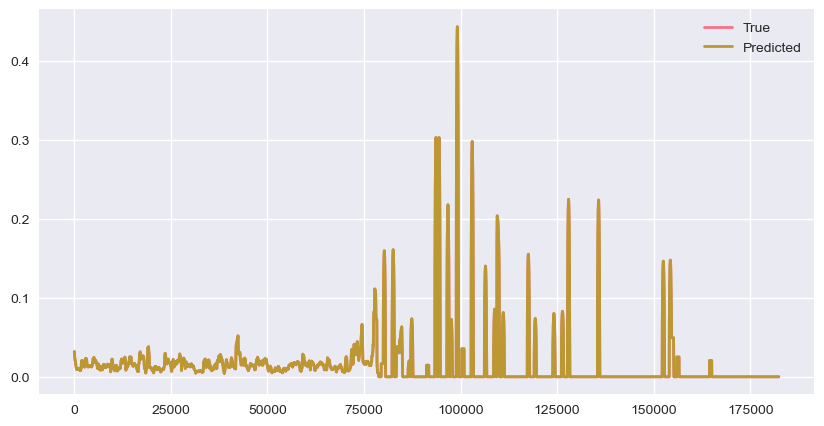

In [106]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for VRSK

In [107]:
y_VRSK = y['volatility_VRSK_1']
X_1_VRSK = X[['volatility_VRSK_1', 'volatility_VRSK_5', 'volatility_VRSK_30']]

In [108]:
X_1_VRSK_train = X_1_VRSK.iloc[:round(len(X_1_VRSK)*0.8), :]
X_1_VRSK_test = X_1_VRSK.iloc[round(len(X_1_VRSK)*0.8):, :]

y_VRSK_train = y_VRSK[:round(len(X_1_VRSK)*0.8)]
y_VRSK_test = y_VRSK[round(len(X_1_VRSK)*0.8):]

### Ridge

In [135]:
coefs_ridge_4 = []   
mae_train_ridge_4 = [] 
mae_test_ridge_4 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_VRSK_train, y_VRSK_train)
    coefs_ridge_4.append(ridge.coef_)
    mae_train_ridge_4.append(mean_absolute_error(y_VRSK_train, ridge.predict(X_1_VRSK_train)))
    mae_test_ridge_4.append(mean_absolute_error(y_VRSK_test, ridge.predict(X_1_VRSK_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [137]:
finally_alpha_4 = alphas_ridge[np.argmin(mae_test_ridge_4)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.015557312722685084,
 0.32936391995662484)

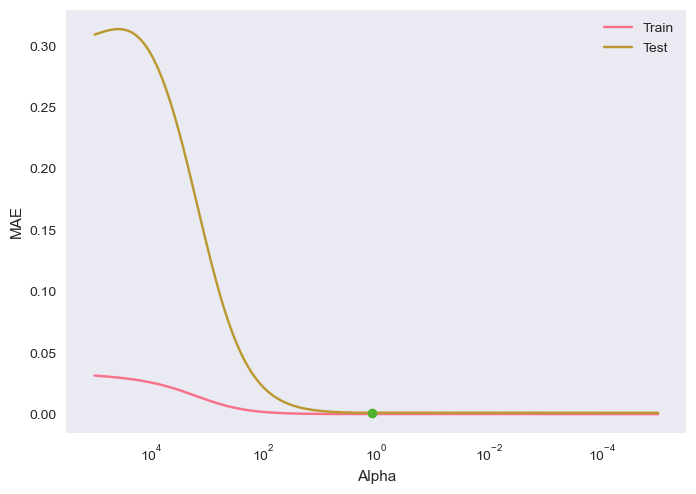

In [139]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_4, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_4, label = 'Test')

ax.plot(finally_alpha_4, mae_test_ridge_4[np.argmin(mae_test_ridge_4)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [141]:
ridge_4 = Ridge(alpha = finally_alpha_4, max_iter=1000, tol=1e-4, random_state=42)
ridge_4.fit(X_1_VRSK_train, y_VRSK_train)
y_VRSK_1_predict = ridge_4.predict(X_1_VRSK_test)

In [143]:
vrsk_base_mae = mean_absolute_error(y_VRSK_test, y_VRSK_1_predict)
vrsk_base_r2 = r2_score(y_VRSK_test, y_VRSK_1_predict)
vrsk_base_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_1_predict)
print(f'Base MAE: {vrsk_base_mae}')
print(f'Base R2: {vrsk_base_r2}')
print(f'Base Sign Accuracy: {vrsk_base_sign_acc}')

Base MAE: 0.001155005918539976
Base R2: 0.9999365086701899
Base Sign Accuracy: 0.9998794137314873


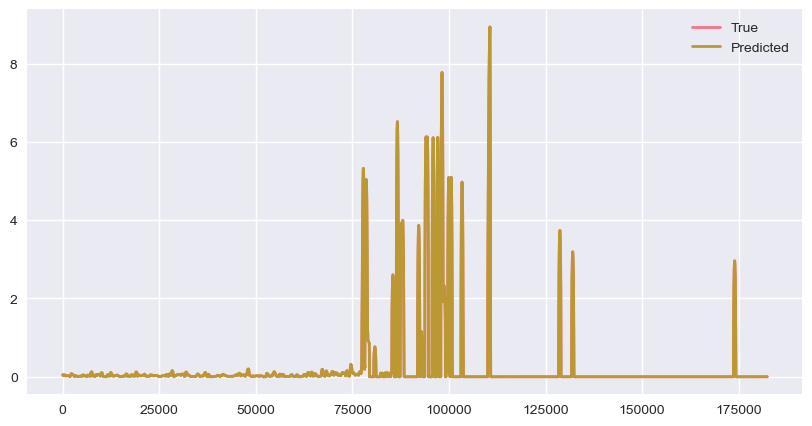

In [145]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for VRSK

In [109]:
X_2_VRSK = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_VRSK_1',
              'volatility_VRSK_5', 'volatility_VRSK_30', 'mean_vol_ANSS_MRVL_FAST', 'std_vol_ANSS_MRVL_FAST', 
              'spread_QQQ', 'spread_VXX', 'spread_SPY', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY',
              'spread_changes_QQQ', 'spread_changes_VRSK', 'cnt_imbalance_VRSK', 'vol_imbalance_VRSK',
              'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY',
              'vol_imbalance_SPY', 'mean_spread_ANSS_MRVL_FAST', 'mean_spread_chs_ANSS_MRVL_FAST',
              'mean_cnt_imb_ANSS_MRVL_FAST', 'mean_vol_imb_ANSS_MRVL_FAST']]

In [110]:
X_2_VRSK_train = X_2_VRSK.iloc[:round(len(X_2_VRSK)*0.8), :]
X_2_VRSK_test = X_2_VRSK.iloc[round(len(X_2_VRSK)*0.8):, :]

### XGBoost

In [209]:
best_model_vrsk_xgb, search_vrsk_xgb = tune_xgb_pipeline(X_2_VRSK_train, y_VRSK_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -0.0004630694530364784
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [210]:
selected_vrsk_xgb = get_selected_features(best_model_vrsk_xgb, X_2_VRSK_train)
print(f'Selected features: {selected_vrsk_xgb}')

Selected features: ['volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_VRSK_1', 'volatility_VRSK_5', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ', 'spread_changes_VRSK', 'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ']


In [211]:
y_VRSK_2_predict = best_model_vrsk_xgb.predict(X_2_VRSK_test)

In [212]:
vrsk_xgb_mae = mean_absolute_error(y_VRSK_test, y_VRSK_2_predict)
vrsk_xgb_r2 = r2_score(y_VRSK_test, y_VRSK_2_predict)
vrsk_xgb_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_2_predict)
print(f'XGB MAE: {vrsk_xgb_mae}')
print(f'XGB R2: {vrsk_xgb_r2}')
print(f'XGB Sign Accuracy: {vrsk_xgb_sign_acc}')

XGB MAE: 0.2420048736463582
XGB R2: 0.0925065067088594
XGB Sign Accuracy: 0.9997807522390677


In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Catboost

In [214]:
best_model_vrsk_catboost, search_vrsk_catboost = tune_catboost_pipeline(X_2_VRSK_train, y_VRSK_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -0.0005351188684283389
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 848
  model__l2_leaf_reg: 5
  model__learning_rate: 0.06021310185147604
  model__random_strength: 1.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 5
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [215]:
selected_vrsk_catboost = get_selected_features(best_model_vrsk_catboost, X_2_VRSK_train)
print(f'Selected features: {selected_vrsk_catboost}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_VRSK_1', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY', 'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'mean_vol_imb_ANSS_MRVL_FAST']


In [216]:
y_VRSK_3_predict = best_model_vrsk_catboost.predict(X_2_VRSK_test)

In [217]:
vrsk_catboost_mae = mean_absolute_error(y_VRSK_test, y_VRSK_3_predict)
vrsk_catboost_r2 = r2_score(y_VRSK_test, y_VRSK_3_predict)
vrsk_catboost_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_3_predict)
print(f'CatBoost MAE: {vrsk_catboost_mae}')
print(f'CatBoost R2: {vrsk_catboost_r2}')
print(f'CatBoost Sign Accuracy: {vrsk_catboost_sign_acc}')

CatBoost MAE: 0.24185532202495877
CatBoost R2: 0.07794786225852679
CatBoost Sign Accuracy: 0.9999671128358602


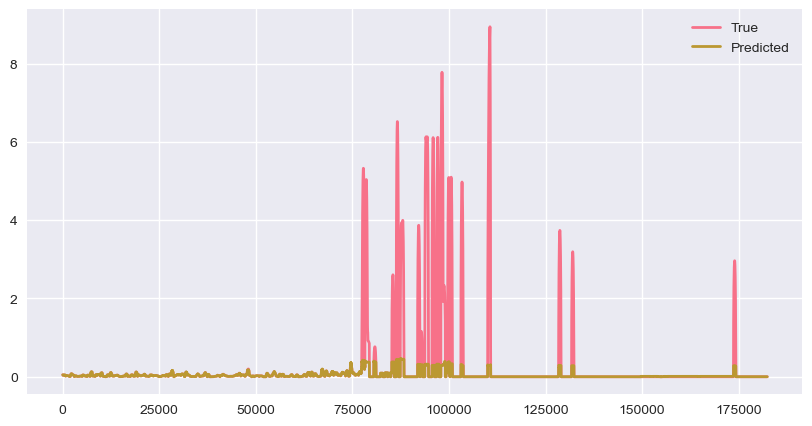

In [218]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [121]:
X_3_VRSK_train = X_2_VRSK_train[['volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_VRSK_1',
                   'volatility_VRSK_5', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ',
                   'spread_changes_VRSK', 'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ']]
X_3_VRSK_test = X_2_VRSK_test[['volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_VRSK_1',
                   'volatility_VRSK_5', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY', 'spread_changes_QQQ',
                   'spread_changes_VRSK', 'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ']]

In [152]:
best_model_VRSK_ridge, search_VRSK_ridge = tune_ridge(X_3_VRSK_train, y_VRSK_train)
y_VRSK_4_predict = best_model_VRSK_ridge.predict(X_3_VRSK_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.0001222251755805187
Best params:
  model__alpha: 48.42462052511469
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: saga
  model__tol: 2.303699023037864e-05


In [193]:
vrsk_ridge_mae = mean_absolute_error(y_VRSK_test, y_VRSK_4_predict)
vrsk_ridge_r2 = r2_score(y_VRSK_test, y_VRSK_4_predict)
vrsk_ridge_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_4_predict)
print(f'Ridge MAE: {vrsk_ridge_mae}')
print(f'Ridge R2: {vrsk_ridge_r2}')
print(f'Ridge Sign Accuracy: {vrsk_ridge_sign_acc}')

Ridge MAE: 0.0024450587552750183
Ridge R2: 0.9999324526848529
Ridge Sign Accuracy: 0.9994409182096228


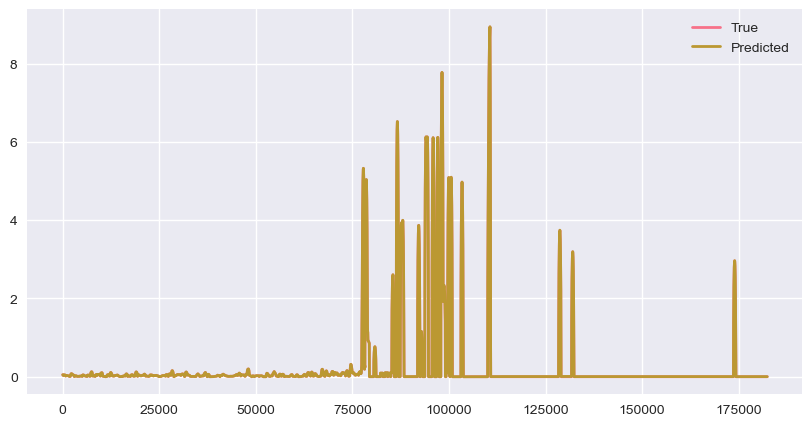

In [195]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [197]:
X_4_VRSK_train = X_2_VRSK_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5',
                   'volatility_VXX_30', 'volatility_VRSK_1', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY',
                   'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'mean_vol_imb_ANSS_MRVL_FAST']]
X_4_VRSK_test = X_2_VRSK_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5',
                   'volatility_VXX_30', 'volatility_VRSK_1', 'volatility_VRSK_30', 'spread_VRSK', 'spread_changes_VXX', 'spread_changes_SPY',
                   'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'mean_vol_imb_ANSS_MRVL_FAST']]

In [199]:
best_model_VRSK_ridge_2, search_VRSK_ridge_2 = tune_ridge(X_4_VRSK_train, y_VRSK_train)
y_VRSK_5_predict = best_model_VRSK_ridge_2.predict(X_4_VRSK_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.00011990883285681942
Best params:
  model__alpha: 3.24329687482488e-05
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: lsqr
  model__tol: 3.727925903376984e-05


In [200]:
vrsk_ridge_2_mae = mean_absolute_error(y_VRSK_test, y_VRSK_5_predict)
vrsk_ridge_2_r2 = r2_score(y_VRSK_test, y_VRSK_5_predict)
vrsk_ridge_2_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_5_predict)
print(f'Ridge MAE: {vrsk_ridge_2_mae}')
print(f'Ridge R2: {vrsk_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {vrsk_ridge_2_sign_acc}')

Ridge MAE: 0.002077808655868165
Ridge R2: 0.9999342388998309
Ridge Sign Accuracy: 0.9996930531346948


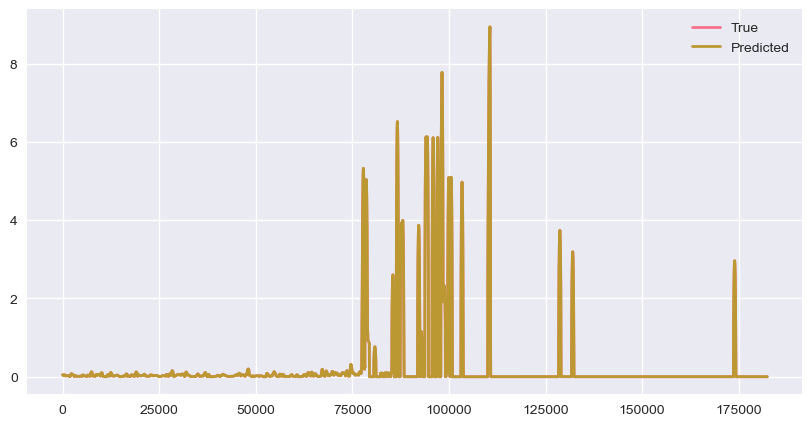

In [201]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [111]:
best_model_VRSK_elnet, search_VRSK_elnet = tune_elasticnet(X_2_VRSK_train, y_VRSK_train, n_iter=25, cv_splits=5)
y_VRSK_6_predict = best_model_VRSK_elnet.predict(X_2_VRSK_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -0.00011841602957307885
Best params:
  model__alpha: 3.6726120005986885e-06
  model__fit_intercept: True
  model__l1_ratio: 0.09310276780589921
  model__tol: 0.0003880279700786684
  select__estimator__alpha: 0.031775345821188294
  select__estimator__l1_ratio: 0.9266202914546536
  select__estimator__tol: 2.2704877557909207e-06
  select__max_features: 8
  select__threshold: 1e-08


In [112]:
best_model_VRSK_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.031775345821188294,
                                                      l1_ratio=0.9266202914546536,
                                                      max_iter=200000,
                                                      random_state=42,
                                                      selection='random',
                                                      tol=2.2704877557909207e-06),
                                 max_features=8, threshold=1e-08)),
                ('model',
                 ElasticNet(alpha=3.6726120005986885e-06,
                            l1_ratio=0.09310276780589921, max_iter=200000,
                            random_state=42, tol=0.0003880279700786684))])

In [113]:
vrsk_elnet_mae = mean_absolute_error(y_VRSK_test, y_VRSK_6_predict)
vrsk_elnet_r2 = r2_score(y_VRSK_test, y_VRSK_6_predict)
vrsk_elnet_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_6_predict)
print(f'Elastic Net MAE: {vrsk_elnet_mae}')
print(f'Elastic Net R2: {vrsk_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {vrsk_elnet_sign_acc}')

Elastic Net MAE: 0.0010402728411367079
Elastic Net R2: 0.9999368733645126
Elastic Net Sign Accuracy: 1.0


In [114]:
selected_vrsk_elnet = get_selected_features(best_model_VRSK_elnet, X_2_VRSK_train)
print(f'Selected features: {selected_vrsk_elnet}')

Selected features: ['volatility_VRSK_1']


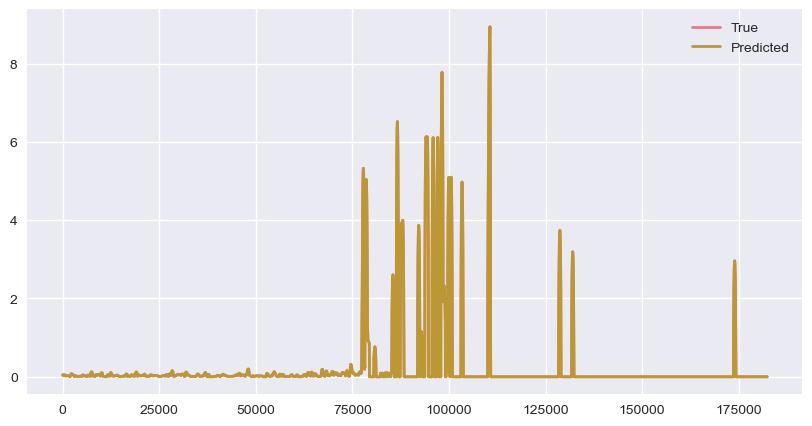

In [115]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for MRVL

In [116]:
y_MRVL = y['volatility_MRVL_1']
X_1_MRVL = X[['volatility_MRVL_1', 'volatility_MRVL_5', 'volatility_MRVL_30']]

In [117]:
X_1_MRVL_train = X_1_MRVL.iloc[:round(len(X_1_MRVL)*0.8), :]
X_1_MRVL_test = X_1_MRVL.iloc[round(len(X_1_MRVL)*0.8):, :]

y_MRVL_train = y_MRVL[:round(len(X_1_MRVL)*0.8)]
y_MRVL_test = y_MRVL[round(len(X_1_MRVL)*0.8):]

### Ridge

In [113]:
coefs_ridge_5 = []   
mae_train_ridge_5 = [] 
mae_test_ridge_5 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_MRVL_train, y_MRVL_train)
    coefs_ridge_5.append(ridge.coef_)
    mae_train_ridge_5.append(mean_absolute_error(y_MRVL_train, ridge.predict(X_1_MRVL_train)))
    mae_test_ridge_5.append(mean_absolute_error(y_MRVL_test, ridge.predict(X_1_MRVL_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [114]:
finally_alpha_5 = alphas_ridge[np.argmin(mae_test_ridge_5)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.0011088586796961031,
 0.024291806311763715)

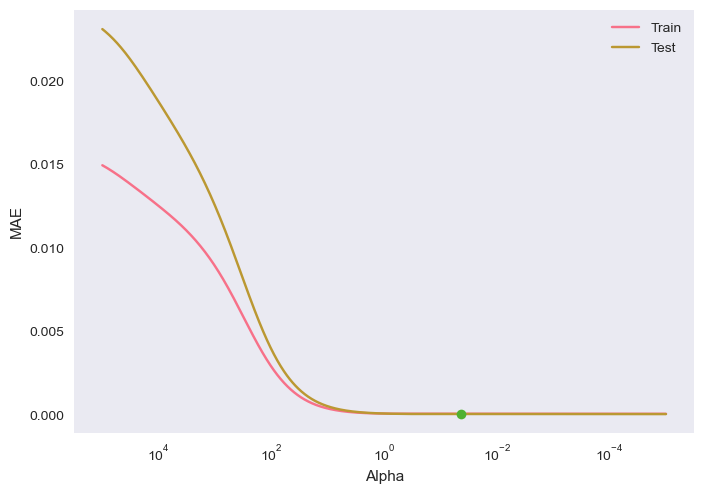

In [115]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_5, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_5, label = 'Test')

ax.plot(finally_alpha_5, mae_test_ridge_5[np.argmin(mae_test_ridge_5)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [116]:
ridge_5 = Ridge(alpha = finally_alpha_5, max_iter=1000, tol=1e-4, random_state=42)
ridge_5.fit(X_1_MRVL_train, y_MRVL_train)
y_MRVL_1_predict = ridge_5.predict(X_1_MRVL_test)

In [117]:
mrvl_base_mae = mean_absolute_error(y_MRVL_test, y_MRVL_1_predict)
mrvl_base_r2 = r2_score(y_MRVL_test, y_MRVL_1_predict)
mrvl_base_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_1_predict)
print(f'Base MAE: {mrvl_base_mae}')
print(f'Base R2: {mrvl_base_r2}')
print(f'Base Sign Accuracy: {mrvl_base_sign_acc}')

Base MAE: 4.571700173388877e-05
Base R2: 0.9999726688592191
Base Sign Accuracy: 0.9998822282416676


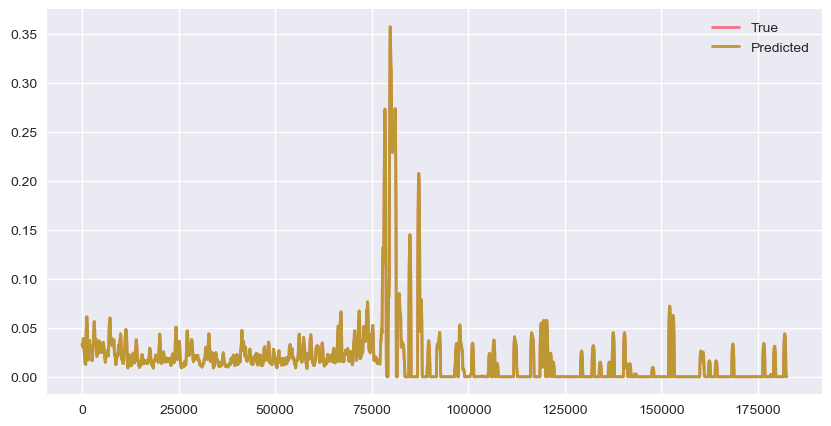

In [118]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for MRVL

In [118]:
X_2_MRVL = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_MRVL_1',
              'volatility_MRVL_5', 'volatility_MRVL_30', 'mean_vol_ANSS_VRSK_FAST', 'std_vol_ANSS_VRSK_FAST', 
              'spread_QQQ', 'spread_VXX', 'spread_SPY', 'spread_MRVL', 'spread_changes_VXX', 'spread_changes_SPY',
              'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_MRVL',
              'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY',
              'vol_imbalance_SPY', 'mean_spread_ANSS_VRSK_FAST', 'mean_spread_chs_ANSS_VRSK_FAST',
              'mean_cnt_imb_ANSS_VRSK_FAST', 'mean_vol_imb_ANSS_VRSK_FAST']]

In [119]:
X_2_MRVL_train = X_2_MRVL.iloc[:round(len(X_2_MRVL)*0.8), :]
X_2_MRVL_test = X_2_MRVL.iloc[round(len(X_2_MRVL)*0.8):, :]

### XGBoost

In [75]:
best_model_mrvl_xgb, search_mrvl_xgb = tune_xgb_pipeline(X_2_MRVL_train, y_MRVL_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -0.00017526551585288701
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [76]:
selected_mrvl_xgb = get_selected_features(best_model_mrvl_xgb, X_2_MRVL_train)
print(f'Selected features: {selected_mrvl_xgb}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5', 'volatility_MRVL_30', 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_QQQ', 'vol_imbalance_VXX', 'mean_spread_chs_ANSS_VRSK_FAST', 'mean_cnt_imb_ANSS_VRSK_FAST']


In [77]:
y_MRVL_2_predict = best_model_mrvl_xgb.predict(X_2_MRVL_test)

In [78]:
mrvl_xgb_mae = mean_absolute_error(y_MRVL_test, y_MRVL_2_predict)
mrvl_xgb_r2 = r2_score(y_MRVL_test, y_MRVL_2_predict)
mrvl_xgb_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_2_predict)
print(f'XGB MAE: {mrvl_xgb_mae}')
print(f'XGB R2: {mrvl_xgb_r2}')
print(f'XGB Sign Accuracy: {mrvl_xgb_sign_acc}')

XGB MAE: 0.003466882263300053
XGB R2: 0.934093875790152
XGB Sign Accuracy: 1.0


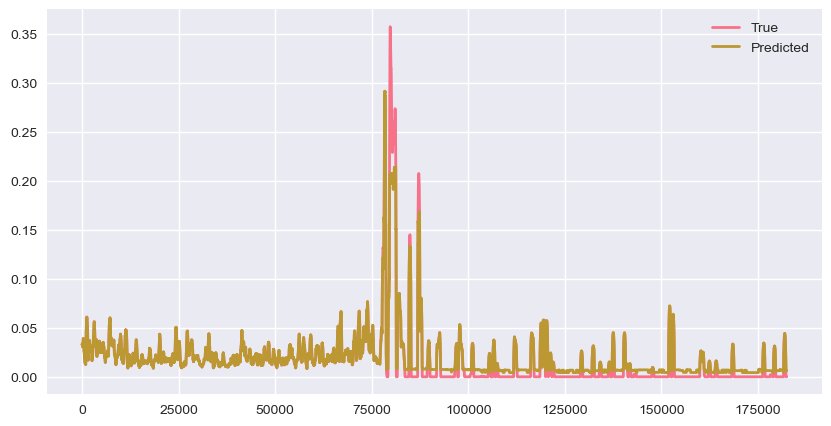

In [79]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Catboost

In [80]:
best_model_mrvl_catboost, search_mrvl_catboost = tune_catboost_pipeline(X_2_MRVL_train, y_MRVL_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -0.00031495343224515095
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 848
  model__l2_leaf_reg: 5
  model__learning_rate: 0.06021310185147604
  model__random_strength: 1.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 5
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [81]:
selected_mrvl_catboost = get_selected_features(best_model_mrvl_catboost, X_2_MRVL_train)
print(f'Selected features: {selected_mrvl_catboost}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5', 'volatility_MRVL_30', 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_VXX', 'mean_cnt_imb_ANSS_VRSK_FAST', 'mean_vol_imb_ANSS_VRSK_FAST']


In [90]:
y_MRVL_3_predict = best_model_mrvl_catboost.predict(X_2_MRVL_test)

In [92]:
mrvl_catboost_mae = mean_absolute_error(y_MRVL_test, y_MRVL_3_predict)
mrvl_catboost_r2 = r2_score(y_MRVL_test, y_MRVL_3_predict)
mrvl_catboost_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_3_predict)
print(f'CatBoost MAE: {mrvl_catboost_mae}')
print(f'CatBoost R2: {mrvl_catboost_r2}')
print(f'CatBoost Sign Accuracy: {mrvl_catboost_sign_acc}')

CatBoost MAE: 0.0037300157248381163
CatBoost R2: 0.9355536189410859
CatBoost Sign Accuracy: 1.0


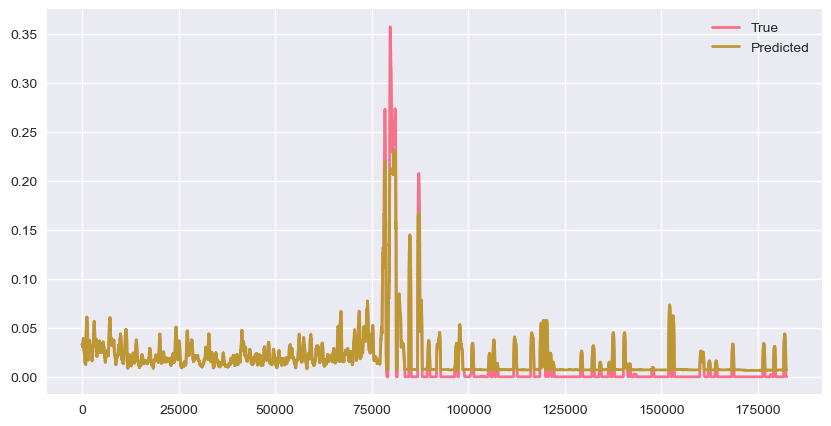

In [94]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [99]:
X_3_MRVL_train = X_2_MRVL_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30',
                                 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5', 'volatility_MRVL_30',
                                 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_QQQ', 'vol_imbalance_VXX',
                                 'mean_spread_chs_ANSS_VRSK_FAST', 'mean_cnt_imb_ANSS_VRSK_FAST']]
X_3_MRVL_test = X_2_MRVL_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30',
                                 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5', 'volatility_MRVL_30',
                                 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_QQQ', 'vol_imbalance_VXX',
                                 'mean_spread_chs_ANSS_VRSK_FAST', 'mean_cnt_imb_ANSS_VRSK_FAST']]

In [101]:
best_model_MRVL_ridge, search_MRVL_ridge = tune_ridge(X_3_MRVL_train, y_MRVL_train)
y_MRVL_4_predict = best_model_MRVL_ridge.predict(X_3_MRVL_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -6.308004562837273e-05
Best params:
  model__alpha: 93.94762824378982
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.08062316132568972


In [102]:
mrvl_ridge_mae = mean_absolute_error(y_MRVL_test, y_MRVL_4_predict)
mrvl_ridge_r2 = r2_score(y_MRVL_test, y_MRVL_4_predict)
mrvl_ridge_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_4_predict)
print(f'Ridge MAE: {mrvl_ridge_mae}')
print(f'Ridge R2: {mrvl_ridge_r2}')
print(f'Ridge Sign Accuracy: {mrvl_ridge_sign_acc}')

Ridge MAE: 4.928028425129528e-05
Ridge R2: 0.9999727027482822
Ridge Sign Accuracy: 0.9997101002871819


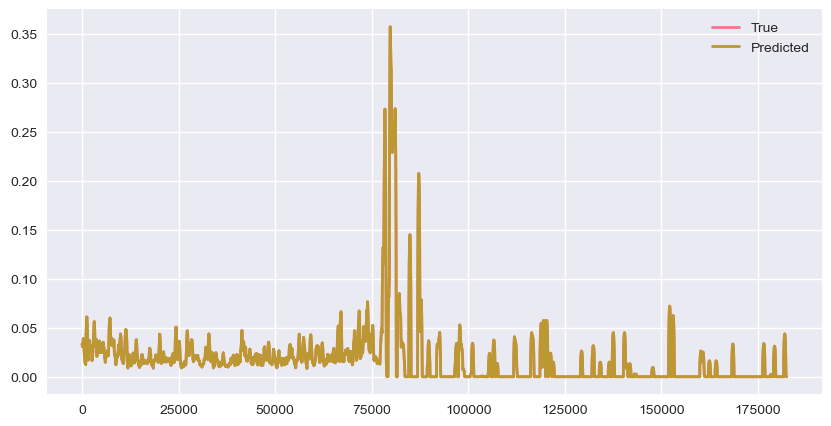

In [103]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [105]:
X_4_MRVL_train = X_2_MRVL_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                                 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5',
                                 'volatility_MRVL_30', 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_VXX',
                                 'mean_cnt_imb_ANSS_VRSK_FAST', 'mean_vol_imb_ANSS_VRSK_FAST']]
X_4_MRVL_test = X_2_MRVL_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                                 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_MRVL_1', 'volatility_MRVL_5',
                                 'volatility_MRVL_30', 'spread_changes_QQQ', 'spread_changes_MRVL', 'cnt_imbalance_MRVL', 'vol_imbalance_VXX',
                                 'mean_cnt_imb_ANSS_VRSK_FAST', 'mean_vol_imb_ANSS_VRSK_FAST']]

In [110]:
best_model_MRVL_ridge_2, search_MRVL_ridge_2 = tune_ridge(X_4_MRVL_train, y_MRVL_train)
y_MRVL_5_predict = best_model_MRVL_ridge_2.predict(X_4_MRVL_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -6.301178358744775e-05
Best params:
  model__alpha: 93.94762824378982
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.08062316132568972


In [111]:
mrvl_ridge_2_mae = mean_absolute_error(y_MRVL_test, y_MRVL_5_predict)
mrvl_ridge_2_r2 = r2_score(y_MRVL_test, y_MRVL_5_predict)
mrvl_ridge_2_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_5_predict)
print(f'Ridge MAE: {mrvl_ridge_2_mae}')
print(f'Ridge R2: {mrvl_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {mrvl_ridge_2_sign_acc}')

Ridge MAE: 4.7939848384408674e-05
Ridge R2: 0.9999725264279204
Ridge Sign Accuracy: 0.9997010409211563


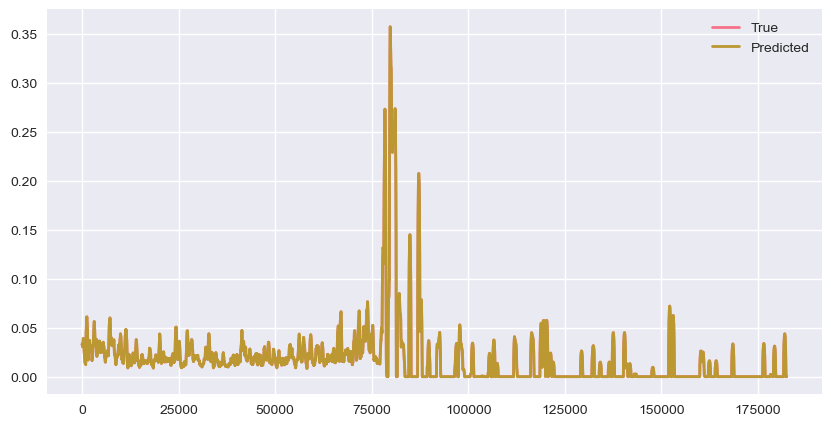

In [112]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [120]:
best_model_MRVL_elnet, search_MRVL_elnet = tune_elasticnet(X_2_MRVL_train, y_MRVL_train, n_iter=25, cv_splits=5)
y_MRVL_6_predict = best_model_MRVL_elnet.predict(X_2_MRVL_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -6.275080183736293e-05
Best params:
  model__alpha: 4.795579858030172e-07
  model__fit_intercept: True
  model__l1_ratio: 0.5414479738275658
  model__tol: 6.069285921193291e-05
  select__estimator__alpha: 1.3891530890192501e-05
  select__estimator__l1_ratio: 0.8349909854191873
  select__estimator__tol: 0.0008485420586212643
  select__max_features: 10
  select__threshold: 1e-07


In [121]:
mrvl_elnet_mae = mean_absolute_error(y_MRVL_test, y_MRVL_6_predict)
mrvl_elnet_r2 = r2_score(y_MRVL_test, y_MRVL_6_predict)
mrvl_elnet_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_6_predict)
print(f'Elastic Net MAE: {mrvl_elnet_mae}')
print(f'Elastic Net R2: {mrvl_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {mrvl_elnet_sign_acc}')

Elastic Net MAE: 4.469863541901367e-05
Elastic Net R2: 0.999972598883111
Elastic Net Sign Accuracy: 1.0


In [122]:
selected_mrvl_elnet = get_selected_features(best_model_MRVL_elnet, X_2_MRVL_train)
print(f'Selected features: {selected_mrvl_elnet}')

Selected features: ['volatility_QQQ_30', 'volatility_MRVL_1']


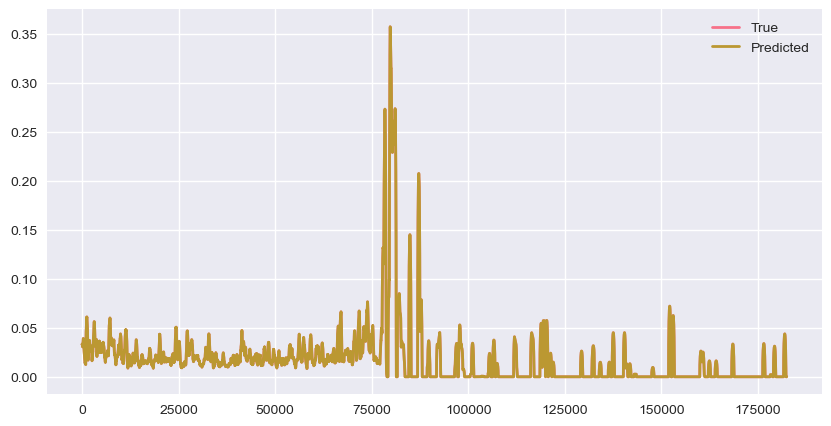

In [123]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for ANSS

In [124]:
y_ANSS = y['volatility_ANSS_1']
X_1_ANSS = X[['volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30']]

In [125]:
X_1_ANSS_train = X_1_ANSS.iloc[:round(len(X_1_ANSS)*0.8), :]
X_1_ANSS_test = X_1_ANSS.iloc[round(len(X_1_ANSS)*0.8):, :]

y_ANSS_train = y_ANSS[:round(len(X_1_ANSS)*0.8)]
y_ANSS_test = y_ANSS[round(len(X_1_ANSS)*0.8):]

### Ridge

In [95]:
coefs_ridge_6 = []   
mae_train_ridge_6 = [] 
mae_test_ridge_6 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_ANSS_train, y_ANSS_train)
    coefs_ridge_6.append(ridge.coef_)
    mae_train_ridge_6.append(mean_absolute_error(y_ANSS_train, ridge.predict(X_1_ANSS_train)))
    mae_test_ridge_6.append(mean_absolute_error(y_ANSS_test, ridge.predict(X_1_ANSS_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [96]:
finally_alpha_6 = alphas_ridge[np.argmin(mae_test_ridge_6)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.0037803745550658747,
 0.08249900974171254)

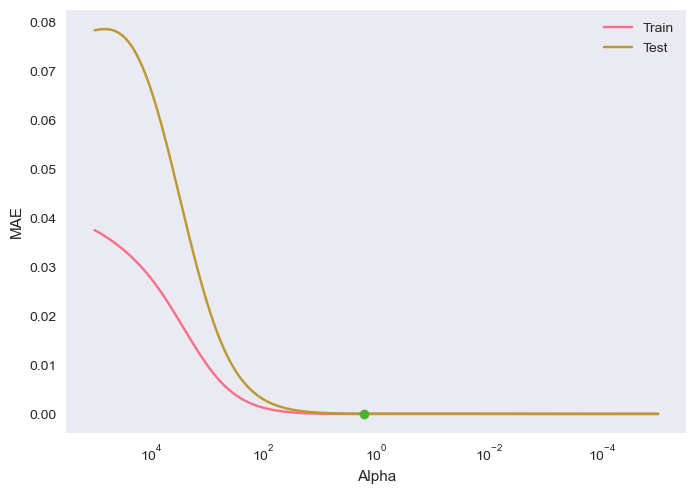

In [97]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_6, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_6, label = 'Test')

ax.plot(finally_alpha_6, mae_test_ridge_6[np.argmin(mae_test_ridge_6)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [101]:
ridge_6 = Ridge(alpha = finally_alpha_6, max_iter=1000, tol=1e-4, random_state=42)
ridge_6.fit(X_1_ANSS_train, y_ANSS_train)
y_ANSS_1_predict = ridge_6.predict(X_1_ANSS_test)

In [103]:
anss_base_mae = mean_absolute_error(y_ANSS_test, y_ANSS_1_predict)
anss_base_r2 = r2_score(y_ANSS_test, y_ANSS_1_predict)
anss_base_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_1_predict)
print(f'Base MAE: {anss_base_mae}')
print(f'Base R2: {anss_base_r2}')
print(f'Base Sign Accuracy: {anss_base_sign_acc}')

Base MAE: 0.00021762553926023677
Base R2: 0.9999453517185044
Base Sign Accuracy: 0.9999762752075919


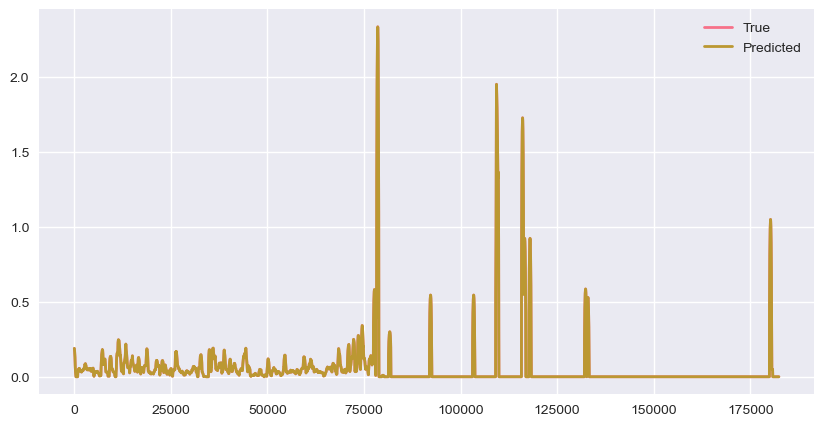

In [119]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for ANSS¶

In [126]:
X_2_ANSS = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_ANSS_1',
              'volatility_ANSS_5', 'volatility_ANSS_30', 'mean_vol_MRVL_VRSK_FAST', 'std_vol_MRVL_VRSK_FAST', 
              'spread_QQQ', 'spread_VXX', 'spread_SPY', 'spread_ANSS', 'spread_changes_VXX', 'spread_changes_SPY',
              'spread_changes_QQQ', 'spread_changes_ANSS', 'cnt_imbalance_ANSS', 'vol_imbalance_ANSS',
              'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY',
              'vol_imbalance_SPY', 'mean_spread_MRVL_VRSK_FAST', 'mean_spread_chs_MRVL_VRSK_FAST',
              'mean_cnt_imb_MRVL_VRSK_FAST', 'mean_vol_imb_MRVL_VRSK_FAST']]

In [127]:
X_2_ANSS_train = X_2_ANSS.iloc[:round(len(X_2_ANSS)*0.8), :]
X_2_ANSS_test = X_2_ANSS.iloc[round(len(X_2_ANSS)*0.8):, :]

### XGBoost

In [124]:
best_model_anss_xgb, search_anss_xgb = tune_xgb_pipeline(X_2_ANSS_train, y_ANSS_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -0.00043800364687722503
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [126]:
selected_anss_xgb = get_selected_features(best_model_anss_xgb, X_2_ANSS_train)
print(f'Selected features: {selected_anss_xgb}')

Selected features: ['volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30', 'mean_vol_MRVL_VRSK_FAST', 'std_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_VXX', 'spread_changes_ANSS', 'cnt_imbalance_ANSS', 'vol_imbalance_SPY', 'mean_spread_chs_MRVL_VRSK_FAST']


In [139]:
y_ANSS_2_predict = best_model_anss_xgb.predict(X_2_ANSS_test)

In [140]:
anss_xgb_mae = mean_absolute_error(y_ANSS_test, y_ANSS_2_predict)
anss_xgb_r2 = r2_score(y_ANSS_test, y_ANSS_2_predict)
anss_xgb_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_2_predict)
print(f'XGB MAE: {anss_xgb_mae}')
print(f'XGB R2: {anss_xgb_r2}')
print(f'XGB Sign Accuracy: {anss_xgb_sign_acc}')

XGB MAE: 0.024626416801260625
XGB R2: 0.5593025023731271
XGB Sign Accuracy: 0.999988137603796


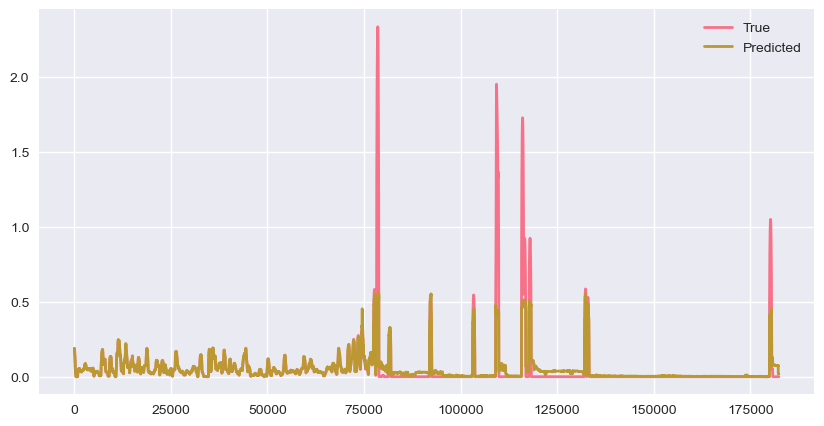

In [176]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### CatBoost

In [128]:
best_model_anss_catboost, search_anss_catboost = tune_catboost_pipeline(X_2_ANSS_train, y_ANSS_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -0.0008088219828449924
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 963
  model__l2_leaf_reg: 20
  model__learning_rate: 0.07217034889329342
  model__random_strength: 2.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 3
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [129]:
selected_anss_catboost = get_selected_features(best_model_anss_catboost, X_2_ANSS_train)
print(f'Selected features: {selected_anss_catboost}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30', 'mean_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_QQQ', 'cnt_imbalance_ANSS', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'mean_vol_imb_MRVL_VRSK_FAST']


In [138]:
y_ANSS_3_predict = best_model_anss_catboost.predict(X_2_ANSS_test)

In [219]:
anss_catboost_mae = mean_absolute_error(y_ANSS_test, y_ANSS_3_predict)
anss_catboost_r2 = r2_score(y_ANSS_test, y_ANSS_3_predict)
anss_catboost_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_3_predict)
print(f'XGB MAE: {anss_catboost_mae}')
print(f'XGB R2: {anss_catboost_r2}')
print(f'XGB Sign Accuracy: {anss_catboost_sign_acc}')

XGB MAE: 0.015427493720344212
XGB R2: 0.6119561898217787
XGB Sign Accuracy: 0.9998576512455516


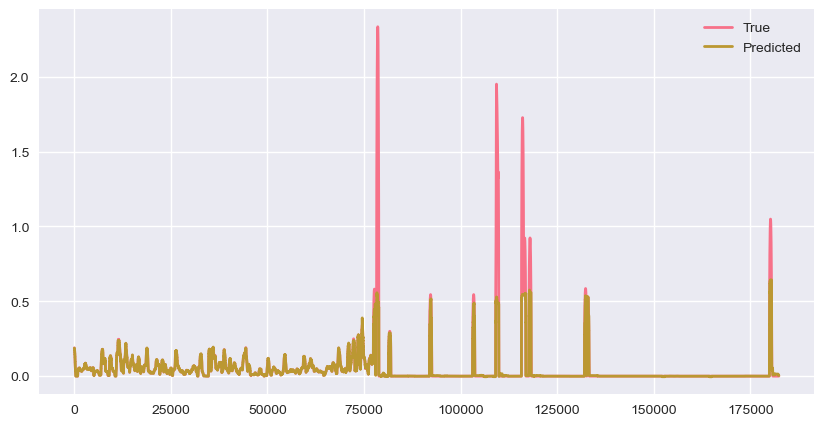

In [221]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [150]:
X_3_ANSS_train = X_2_ANSS_train[['volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30', 'mean_vol_MRVL_VRSK_FAST',
                                 'std_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_VXX', 'spread_changes_ANSS', 'cnt_imbalance_ANSS',
                                 'vol_imbalance_SPY', 'mean_spread_chs_MRVL_VRSK_FAST']]
X_3_ANSS_test = X_2_ANSS_test[['volatility_SPY_30', 'volatility_QQQ_5', 'volatility_QQQ_30', 'volatility_VXX_1', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30', 'mean_vol_MRVL_VRSK_FAST',
                                 'std_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_VXX', 'spread_changes_ANSS', 'cnt_imbalance_ANSS',
                                 'vol_imbalance_SPY', 'mean_spread_chs_MRVL_VRSK_FAST']]

In [152]:
best_model_ANSS_ridge, search_ANSS_ridge = tune_ridge(X_3_ANSS_train, y_ANSS_train)
y_ANSS_4_predict = best_model_ANSS_ridge.predict(X_3_ANSS_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.00014365451408187435
Best params:
  model__alpha: 93.94762824378982
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.08062316132568972


In [155]:
anss_ridge_mae = mean_absolute_error(y_ANSS_test, y_ANSS_4_predict)
anss_ridge_r2 = r2_score(y_ANSS_test, y_ANSS_4_predict)
anss_ridge_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_4_predict)
print(f'Ridge MAE: {anss_ridge_mae}')
print(f'Ridge R2: {anss_ridge_r2}')
print(f'Ridge Sign Accuracy: {anss_ridge_sign_acc}')

Ridge MAE: 0.00386222342903591
Ridge R2: 0.9933178703560849
Ridge Sign Accuracy: 1.0


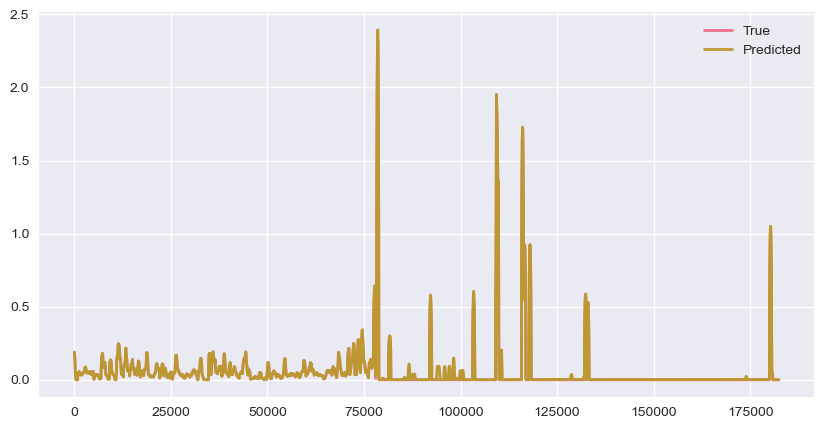

In [157]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [174]:
X_4_ANSS_train = X_2_ANSS_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                                 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30',
                                 'mean_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_QQQ', 'cnt_imbalance_ANSS', 'cnt_imbalance_VXX',
                                 'vol_imbalance_VXX', 'mean_vol_imb_MRVL_VRSK_FAST']]
X_4_ANSS_test = X_2_ANSS_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
                                 'volatility_VXX_1', 'volatility_VXX_30', 'volatility_ANSS_1', 'volatility_ANSS_5', 'volatility_ANSS_30',
                                 'mean_vol_MRVL_VRSK_FAST', 'spread_ANSS', 'spread_changes_QQQ', 'cnt_imbalance_ANSS', 'cnt_imbalance_VXX',
                                 'vol_imbalance_VXX', 'mean_vol_imb_MRVL_VRSK_FAST']]

In [179]:
best_model_ANSS_ridge_2, search_ANSS_ridge_2 = tune_ridge(X_4_ANSS_train, y_ANSS_train)
y_ANSS_5_predict = best_model_ANSS_ridge_2.predict(X_4_ANSS_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -0.00014337762917061159
Best params:
  model__alpha: 93.94762824378982
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: auto
  model__tol: 0.08062316132568972


In [183]:
anss_ridge_2_mae = mean_absolute_error(y_ANSS_test, y_ANSS_5_predict)
anss_ridge_2_r2 = r2_score(y_ANSS_test, y_ANSS_5_predict)
anss_ridge_2_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_5_predict)
print(f'Ridge MAE: {anss_ridge_2_mae}')
print(f'Ridge R2: {anss_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {anss_ridge_2_sign_acc}')

Ridge MAE: 0.000787190156828205
Ridge R2: 0.9999257401039351
Ridge Sign Accuracy: 0.9999762752075919


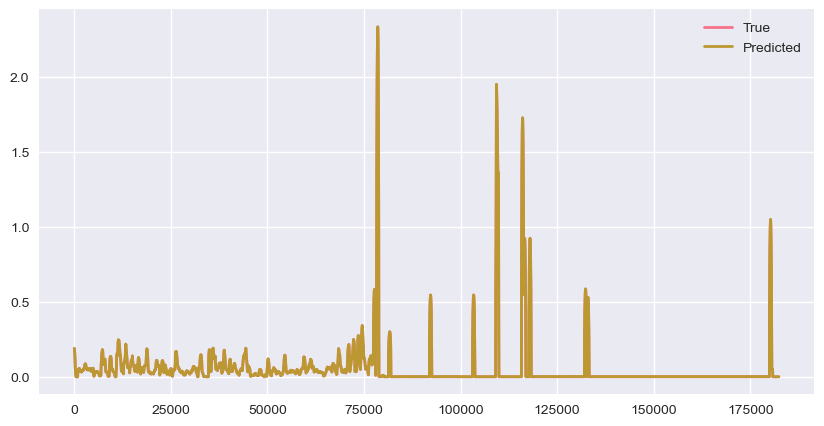

In [184]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [128]:
best_model_ANSS_elnet, search_ANSS_elnet = tune_elasticnet(X_2_ANSS_train, y_ANSS_train, n_iter=25, cv_splits=5)
y_ANSS_6_predict = best_model_ANSS_elnet.predict(X_2_ANSS_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -0.00013853327252314913
Best params:
  model__alpha: 3.6726120005986885e-06
  model__fit_intercept: True
  model__l1_ratio: 0.09310276780589921
  model__tol: 0.0003880279700786684
  select__estimator__alpha: 0.031775345821188294
  select__estimator__l1_ratio: 0.9266202914546536
  select__estimator__tol: 2.2704877557909207e-06
  select__max_features: 8
  select__threshold: 1e-08


In [129]:
anss_elnet_mae = mean_absolute_error(y_ANSS_test, y_ANSS_6_predict)
anss_elnet_r2 = r2_score(y_ANSS_test, y_ANSS_6_predict)
anss_elnet_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_6_predict)
print(f'Elastic Net MAE: {anss_elnet_mae}')
print(f'Elastic Net R2: {anss_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {anss_elnet_sign_acc}')

Elastic Net MAE: 0.000188906611107273
Elastic Net R2: 0.9999454120647532
Elastic Net Sign Accuracy: 1.0


In [130]:
selected_anss_elnet = get_selected_features(best_model_ANSS_elnet, X_2_ANSS_train)
print(f'Selected features: {selected_anss_elnet}')

Selected features: ['volatility_ANSS_1']


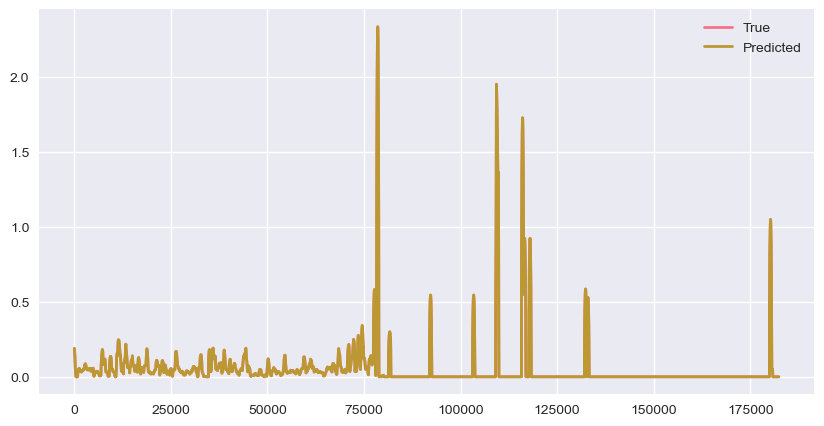

In [131]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Baseline for FAST

In [132]:
y_FAST = y['volatility_FAST_1']
X_1_FAST = X[['volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30']]

In [133]:
X_1_FAST_train = X_1_FAST.iloc[:round(len(X_1_FAST)*0.8), :]
X_1_FAST_test = X_1_FAST.iloc[round(len(X_1_FAST)*0.8):, :]

y_FAST_train = y_FAST[:round(len(X_1_FAST)*0.8)]
y_FAST_test = y_FAST[round(len(X_1_FAST)*0.8):]

### Ridge

In [131]:
coefs_ridge_7 = []   
mae_train_ridge_7 = [] 
mae_test_ridge_7 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_FAST_train, y_FAST_train)
    coefs_ridge_7.append(ridge.coef_)
    mae_train_ridge_7.append(mean_absolute_error(y_FAST_train, ridge.predict(X_1_FAST_train)))
    mae_test_ridge_7.append(mean_absolute_error(y_FAST_test, ridge.predict(X_1_FAST_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [136]:
finally_alpha_7 = alphas_ridge[np.argmin(mae_test_ridge_7)]

In [138]:
ridge_7 = Ridge(alpha = finally_alpha_7, max_iter=1000, tol=1e-4, random_state=42)
ridge_7.fit(X_1_FAST_train, y_FAST_train)
y_FAST_1_predict = ridge_7.predict(X_1_FAST_test)

In [140]:
fast_base_mae = mean_absolute_error(y_FAST_test, y_FAST_1_predict)
fast_base_r2 = r2_score(y_FAST_test, y_FAST_1_predict)
fast_base_sign_acc = sign_accuracy(y_FAST_test, y_FAST_1_predict)
print(f'Base MAE: {fast_base_mae}')
print(f'Base R2: {fast_base_r2}')
print(f'Base Sign Accuracy: {fast_base_sign_acc}')

Base MAE: 3.372932776963103e-05
Base R2: 0.99995358429077
Base Sign Accuracy: 0.9999192497144901


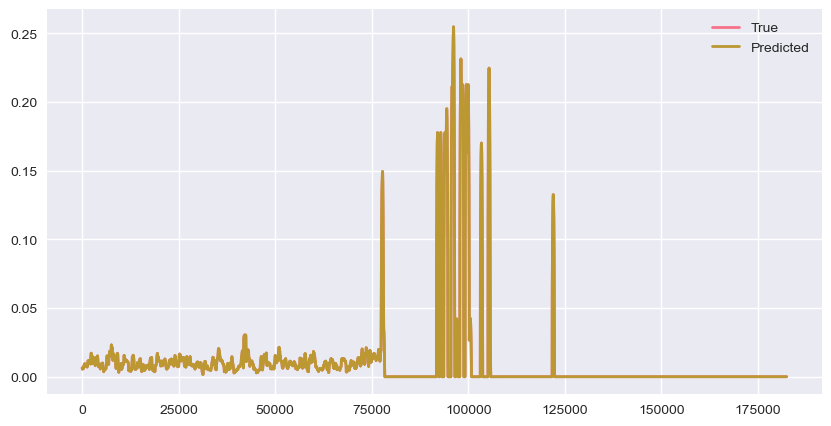

In [142]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

## Pipeline for FAST

In [134]:
X_2_FAST = X[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_1', 'volatility_QQQ_5',
             'volatility_QQQ_30','volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_FAST_1',
              'volatility_FAST_5', 'volatility_FAST_30', 'mean_vol_MRVL_VRSK_ANSS', 'std_vol_MRVL_VRSK_ANSS', 
              'spread_QQQ', 'spread_VXX', 'spread_SPY', 'spread_ANSS', 'spread_changes_VXX', 'spread_changes_SPY',
              'spread_changes_QQQ', 'spread_changes_FAST', 'cnt_imbalance_FAST', 'vol_imbalance_FAST',
              'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'cnt_imbalance_SPY',
              'vol_imbalance_SPY', 'mean_spread_MRVL_VRSK_ANSS', 'mean_spread_chs_MRVL_VRSK_ANSS',
              'mean_cnt_imb_MRVL_VRSK_ANSS', 'mean_vol_imb_MRVL_VRSK_ANSS']]

In [135]:
X_2_FAST_train = X_2_FAST.iloc[:round(len(X_2_FAST)*0.8), :]
X_2_FAST_test = X_2_FAST.iloc[round(len(X_2_FAST)*0.8):, :]

### XGBoost

In [145]:
best_model_fast_xgb, search_fast_xgb = tune_xgb_pipeline(X_2_FAST_train, y_FAST_train, n_iter=60)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best CV score (neg MAE): -5.5340411619827316e-05
Best params:
  model__colsample_bytree: 0.9087527922392981
  model__gamma: 1.2071132455344227e-06
  model__learning_rate: 0.023825093087775827
  model__max_depth: 5
  model__min_child_weight: 3.652331100407901
  model__n_estimators: 1606
  model__reg_alpha: 0.00015074427397856487
  model__reg_lambda: 0.007769444110002182
  model__subsample: 0.9633802245334513
  select__estimator__colsample_bytree: 0.8333567179064482
  select__estimator__learning_rate: 0.008363174022834334
  select__estimator__max_depth: 8
  select__estimator__min_child_weight: 1.0052604559249576
  select__estimator__n_estimators: 562
  select__estimator__reg_alpha: 8.319714412545995e-06
  select__estimator__reg_lambda: 0.5684292221416526
  select__estimator__subsample: 0.8023554715537864
  select__max_features: None
  select__threshold: median


In [146]:
selected_fast_xgb = get_selected_features(best_model_fast_xgb, X_2_FAST_train)
print(f'Selected features: {selected_fast_xgb}')

Selected features: ['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'spread_changes_SPY', 'spread_changes_QQQ', 'spread_changes_FAST', 'cnt_imbalance_FAST', 'vol_imbalance_SPY', 'mean_spread_MRVL_VRSK_ANSS', 'mean_cnt_imb_MRVL_VRSK_ANSS', 'mean_vol_imb_MRVL_VRSK_ANSS']


In [205]:
y_FAST_2_predict = best_model_fast_xgb.predict(X_2_FAST_test)

In [207]:
fast_xgb_mae = mean_absolute_error(y_FAST_test, y_FAST_2_predict)
fast_xgb_r2 = r2_score(y_FAST_test, y_FAST_2_predict)
fast_xgb_sign_acc = sign_accuracy(y_FAST_test, y_FAST_2_predict)
print(f'XGB MAE: {fast_xgb_mae}')
print(f'XGB R2: {fast_xgb_r2}')
print(f'XGB Sign Accuracy: {fast_xgb_sign_acc}')

XGB MAE: 0.0067666518136682095
XGB R2: 0.3396499807191552
XGB Sign Accuracy: 1.0


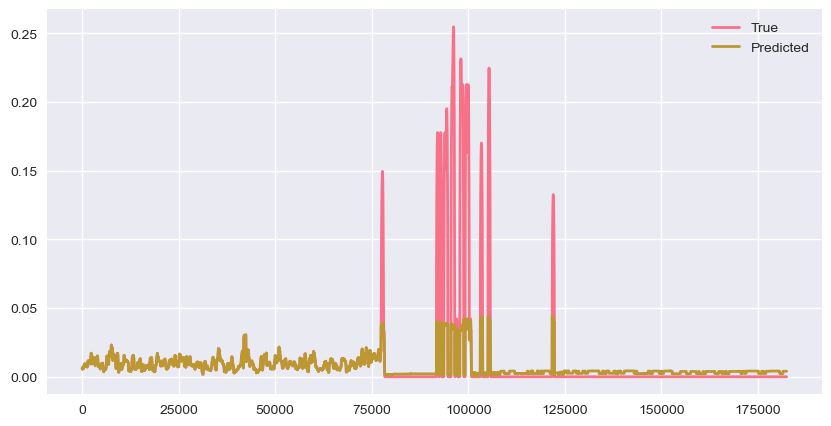

In [209]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### CatBoost

In [147]:
best_model_fast_catboost, search_fast_catboost = tune_catboost_pipeline(X_2_FAST_train, y_FAST_train, n_iter=60)

Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best CV score (neg MAE): -5.853740388392161e-05
Best params:
  model__bagging_temperature: 1.0
  model__depth: 7
  model__grow_policy: SymmetricTree
  model__iterations: 848
  model__l2_leaf_reg: 5
  model__learning_rate: 0.06021310185147604
  model__random_strength: 1.0
  select__estimator__bagging_temperature: 0.0
  select__estimator__depth: 6
  select__estimator__iterations: 300
  select__estimator__l2_leaf_reg: 5
  select__estimator__learning_rate: 0.1
  select__estimator__random_strength: 1.0
  select__max_features: None
  select__threshold: median


In [148]:
selected_fast_catboost = get_selected_features(best_model_fast_catboost, X_2_FAST_train)
print(f'Selected features: {selected_fast_catboost}')

Selected features: ['volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5', 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'mean_vol_MRVL_VRSK_ANSS', 'spread_changes_QQQ', 'cnt_imbalance_FAST', 'vol_imbalance_FAST', 'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'vol_imbalance_SPY', 'mean_vol_imb_MRVL_VRSK_ANSS']


In [211]:
y_FAST_3_predict = best_model_fast_catboost.predict(X_2_FAST_test)

In [217]:
fast_catboost_mae = mean_absolute_error(y_FAST_test, y_FAST_3_predict)
fast_catboost_r2 = r2_score(y_FAST_test, y_FAST_3_predict)
fast_catboost_sign_acc = sign_accuracy(y_FAST_test, y_FAST_3_predict)
print(f'XGB MAE: {fast_catboost_mae}')
print(f'XGB R2: {fast_catboost_r2}')
print(f'XGB Sign Accuracy: {fast_catboost_sign_acc}')

XGB MAE: 0.006649244952502885
XGB R2: 0.3451832684937307
XGB Sign Accuracy: 1.0


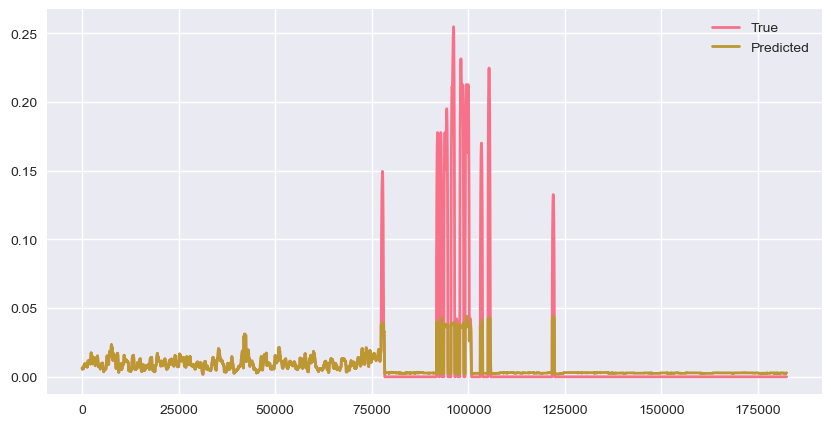

In [213]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_3_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных XGBoost)

In [167]:
X_3_FAST_train = X_2_FAST_train[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'spread_changes_SPY',
                                 'spread_changes_QQQ', 'spread_changes_FAST', 'cnt_imbalance_FAST', 'vol_imbalance_SPY', 'mean_spread_MRVL_VRSK_ANSS',
                                 'mean_cnt_imb_MRVL_VRSK_ANSS', 'mean_vol_imb_MRVL_VRSK_ANSS']]
X_3_FAST_test = X_2_FAST_test[['volatility_SPY_1', 'volatility_SPY_5', 'volatility_SPY_30', 'volatility_QQQ_30', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'spread_changes_SPY',
                                 'spread_changes_QQQ', 'spread_changes_FAST', 'cnt_imbalance_FAST', 'vol_imbalance_SPY', 'mean_spread_MRVL_VRSK_ANSS',
                                 'mean_cnt_imb_MRVL_VRSK_ANSS', 'mean_vol_imb_MRVL_VRSK_ANSS']]

In [169]:
best_model_FAST_ridge, search_FAST_ridge = tune_ridge(X_3_FAST_train, y_FAST_train)
y_FAST_4_predict = best_model_FAST_ridge.predict(X_3_FAST_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -2.0724739041588147e-05
Best params:
  model__alpha: 0.005919451226059309
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: lsqr
  model__tol: 0.00025720264197882334


In [170]:
fast_ridge_mae = mean_absolute_error(y_FAST_test, y_FAST_4_predict)
fast_ridge_r2 = r2_score(y_FAST_test, y_FAST_4_predict)
fast_ridge_sign_acc = sign_accuracy(y_FAST_test, y_FAST_4_predict)
print(f'Ridge MAE: {fast_ridge_mae}')
print(f'Ridge R2: {fast_ridge_r2}')
print(f'Ridge Sign Accuracy: {fast_ridge_sign_acc}')

Ridge MAE: 0.00012453300680891354
Ridge R2: 0.9999365064327463
Ridge Sign Accuracy: 0.9999884642449272


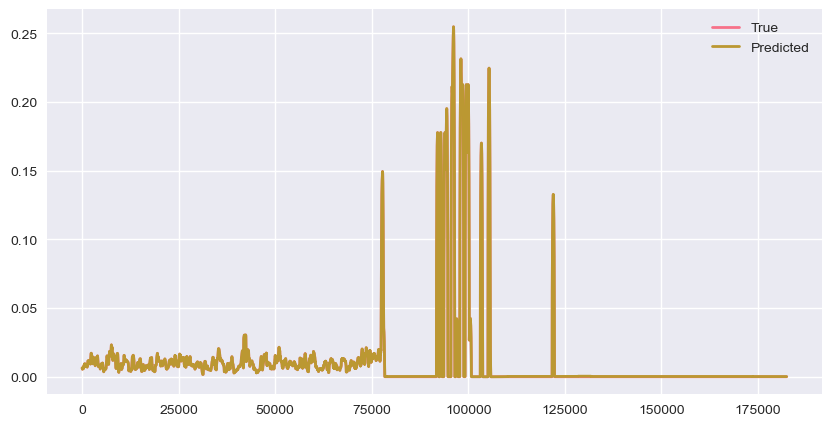

In [171]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_4_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Ridge (на фичах, отобранных CatBoost)

In [180]:
X_4_FAST_train = X_2_FAST_train[['volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'mean_vol_MRVL_VRSK_ANSS',
                                 'spread_changes_QQQ', 'cnt_imbalance_FAST', 'vol_imbalance_FAST', 'cnt_imbalance_VXX', 'vol_imbalance_VXX',
                                 'vol_imbalance_SPY', 'mean_vol_imb_MRVL_VRSK_ANSS']]
X_4_FAST_test = X_2_FAST_test[['volatility_SPY_5', 'volatility_QQQ_1', 'volatility_QQQ_5', 'volatility_VXX_1', 'volatility_VXX_5',
                                 'volatility_VXX_30', 'volatility_FAST_1', 'volatility_FAST_5', 'volatility_FAST_30', 'mean_vol_MRVL_VRSK_ANSS',
                                 'spread_changes_QQQ', 'cnt_imbalance_FAST', 'vol_imbalance_FAST', 'cnt_imbalance_VXX', 'vol_imbalance_VXX',
                                 'vol_imbalance_SPY', 'mean_vol_imb_MRVL_VRSK_ANSS']]

In [181]:
best_model_FAST_ridge_2, search_FAST_ridge_2 = tune_ridge(X_4_FAST_train, y_FAST_train)
y_FAST_5_predict = best_model_FAST_ridge_2.predict(X_4_FAST_test)

Fitting 5 folds for each of 62 candidates, totalling 310 fits

Total iterations: 62
Best CV score (neg MAE): -2.0725742036300856e-05
Best params:
  model__alpha: 0.005919451226059309
  model__fit_intercept: True
  model__max_iter: 10000
  model__solver: lsqr
  model__tol: 0.00025720264197882334


In [182]:
fast_ridge_2_mae = mean_absolute_error(y_FAST_test, y_FAST_5_predict)
fast_ridge_2_r2 = r2_score(y_FAST_test, y_FAST_5_predict)
fast_ridge_2_sign_acc = sign_accuracy(y_FAST_test, y_FAST_5_predict)
print(f'Ridge MAE: {fast_ridge_2_mae}')
print(f'Ridge R2: {fast_ridge_2_r2}')
print(f'Ridge Sign Accuracy: {fast_ridge_2_sign_acc}')

Ridge MAE: 3.4828946532008784e-05
Ridge R2: 0.9999534569752062
Ridge Sign Accuracy: 0.9998846424492716


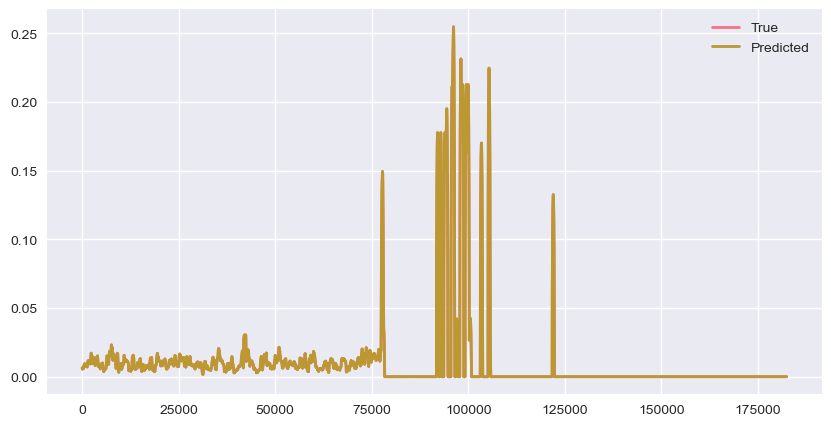

In [185]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_5_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Elastic Net

In [136]:
best_model_FAST_elnet, search_FAST_elnet = tune_elasticnet(X_2_FAST_train, y_FAST_train, n_iter=25, cv_splits=5)
y_FAST_6_predict = best_model_FAST_elnet.predict(X_2_FAST_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV score (neg MAE): -2.058238559891458e-05
Best params:
  model__alpha: 4.795579858030172e-07
  model__fit_intercept: True
  model__l1_ratio: 0.5414479738275658
  model__tol: 6.069285921193291e-05
  select__estimator__alpha: 1.3891530890192501e-05
  select__estimator__l1_ratio: 0.8349909854191873
  select__estimator__tol: 0.0008485420586212643
  select__max_features: 10
  select__threshold: 1e-07


In [202]:
best_model_FAST_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=1.3891530890192501e-05,
                                                      l1_ratio=0.8349909854191873,
                                                      max_iter=200000,
                                                      random_state=42,
                                                      selection='random',
                                                      tol=0.0008485420586212643),
                                 max_features=10, threshold=1e-07)),
                ('model',
                 ElasticNet(alpha=4.795579858030172e-07,
                            l1_ratio=0.5414479738275658, max_iter=200000,
                            random_state=42, tol=6.069285921193291e-05))])

In [137]:
fast_elnet_mae = mean_absolute_error(y_FAST_test, y_FAST_6_predict)
fast_elnet_r2 = r2_score(y_FAST_test, y_FAST_6_predict)
fast_elnet_sign_acc = sign_accuracy(y_FAST_test, y_FAST_6_predict)
print(f'Elastic Net MAE: {fast_elnet_mae}')
print(f'Elastic Net R2: {fast_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {fast_elnet_sign_acc}')

Elastic Net MAE: 3.0719381658683175e-05
Elastic Net R2: 0.9999534916160308
Elastic Net Sign Accuracy: 1.0


In [138]:
selected_fast_elnet = get_selected_features(best_model_FAST_elnet, X_2_FAST_train)
print(f'Selected features: {selected_fast_elnet}')

Selected features: ['volatility_FAST_1']


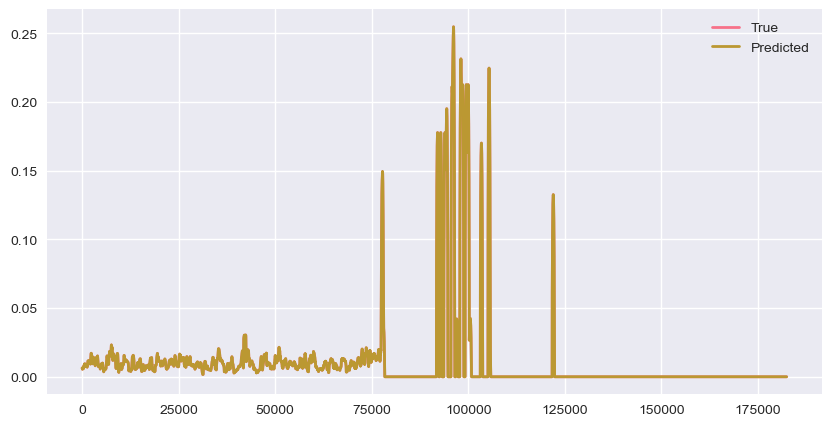

In [139]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_6_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

Вывод: на ограниченной несколькими днями выборке бустинг показал себя довольно плохо. XGBoost и CatBoost не уловили экстремальные скачки волатильности, в отличие от линейных моделей. Наилучшим образом себя показала Elastic Net с собственным отбором фичей - она и будет использована в модифицированном алгоритме.

In [66]:
joblib.dump({'model': best_model_SPY_elnet['model'], 'scaler':  StandardScaler(),
             'features': ['volatility_SPY_1', 'volatility_QQQ_1']}, 'vol_SPY.joblib')

['vol_SPY.joblib']

In [68]:
# joblib.dump({'model': best_model_QQQ_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_QQQ_1']}, 'vol_QQQ.joblib')

In [70]:
# joblib.dump({'model': best_model_VXX_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_QQQ_5', 'volatility_VXX_1']}, 'vol_VXX.joblib')

In [72]:
# joblib.dump({'model': best_model_VRSK_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_VRSK_1']}, 'vol_VRSK.joblib')

In [74]:
# joblib.dump({'model': best_model_MRVL_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_QQQ_30', 'volatility_MRVL_1']}, 'vol_MRVL.joblib')

In [76]:
# joblib.dump({'model': best_model_ANSS_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_ANSS_1']}, 'vol_ANSS.joblib')

In [78]:
# joblib.dump({'model': best_model_FAST_elnet['model'], 'scaler':  StandardScaler(), 'features': ['volatility_FAST_1']}, 'vol_FAST.joblib')